# Figure 3

## Data preprocessing

In [112]:
# loading functions
library(ggbeeswarm)
library(rstatix)
library(ggpubr)
library(wesanderson)
library(patchwork)
library(ggbreak)
library(gridExtra)
library(pheatmap)
library(scales)
library("readxl")
source("func.R")

### Processing tables

In [113]:
l1_tbl <- read_tsv("../results/crc_pairwise_l1.tsv")
markerlengths <- read_tsv("../results/crc_markerlengths.tsv")
divergence_timing <- read_tsv("../results/crc_divergence_timing.tsv")
mrca_tbl <- read_tsv("../results/crc_mrca_table.tsv")

Rows: 3588 Columns: 6
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): a, b
dbl (4): l1, r, marker, divs

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11683 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): sample, marker, subject
dbl (1): length

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 656 Columns: 4
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): samples, comparison, subject
dbl (1): mrca

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 37 Columns: 3
-- Column spec

In [114]:
normal_samples <- l1_tbl %>%
      mutate(
            subject = str_extract(a, "C[0-9]{1,3}"),
            sample_a = str_extract(a, "(?<=C[0-9]{1,3})[:alpha:][:digit:]*"),
            sample_b = str_extract(b, "(?<=C[0-9]{1,3})[:alpha:][:digit:]*"),
            type_a = str_extract(a, "(?<=C[0-9]{1,3})[:alpha:]"),
            type_b = str_extract(b, "(?<=C[0-9]{1,3})[:alpha:]"),
            suffix_a = str_extract(a, "[:lower:]$"),
            suffix_b = str_extract(b, "[:lower:]$")
      ) %>%
      group_by(subject) %>%
      filter(str_detect(a, "N") | str_detect(b, "N"), !(str_detect(a, "N") & str_detect(b, "N"))) %>%
      mutate(normal = ifelse(str_detect(a, "N"), a, b)) %>%
      select(subject, normal) %>%
      distinct() %>%
      dplyr::slice_head() %>% 
      pull(normal)

In [115]:
# select only the first normal sample
annotated_cmb_cell_divs <- l1_tbl %>%
      mutate(
            subject = str_extract(a, "C[0-9]{1,3}"),
            sample_a = str_extract(a, "(?<=C[0-9]{1,3})[:alpha:][:digit:]*"),
            sample_b = str_extract(b, "(?<=C[0-9]{1,3})[:alpha:][:digit:]*"),
            type_a = str_extract(a, "(?<=C[0-9]{1,3})[:alpha:]"),
            type_b = str_extract(b, "(?<=C[0-9]{1,3})[:alpha:]"),
            suffix_a = str_extract(a, "[:lower:]$"),
            suffix_b = str_extract(b, "[:lower:]$")
      ) %>%
      group_by(subject) %>%
            filter(
                  (!str_detect(a, "N") & !str_detect(b, "N")) |
                        (str_detect(a, "N", negate = TRUE) & (b %in% normal_samples)) |
                        (str_detect(b, "N", negate = TRUE) & (a %in% normal_samples))
            ) %>%
      ungroup()

In [116]:
# transform mrca table into format fo easier plotting 
long_mrca_tbl  <- mrca_tbl  %>% 
    pivot_longer(2:3, names_to="comparison", 
                values_to="mrca_divs") %>% 
     mutate(sample_type = case_when(
         comparison == "all_mrca" ~ "Whole Tumor",
         comparison == "ad_ad_mrca" ~ "Adenoma"
     ))

Defining MSI subjects by whether more than 10% of their mutations are deletion over 1bp:

In [117]:
msi_samples <- markerlengths %>%
    group_by(subject) %>%
    mutate(large_del = (length < (-1))) %>%
    count(large_del) %>%
    mutate(del_frac = n / sum(n)) %>%
    filter(large_del, del_frac > 0.1)
msi_samples
msi_tumors <- msi_samples$subject

subject,large_del,n,del_frac
<chr>,<lgl>,<int>,<dbl>
C102,TRUE,195,0.4987212
C12,TRUE,169,0.6627451
C38,TRUE,135,0.6108597
C6,TRUE,73,0.3160173
C92,TRUE,138,0.5307692
C95,TRUE,144,0.6153846


In [118]:
# ordering subjects from lowest to highest number
subjects <- as.list((markerlengths) %>%
    pull(subject) %>%
    unique()) %>%
    str_sort(numeric=TRUE)

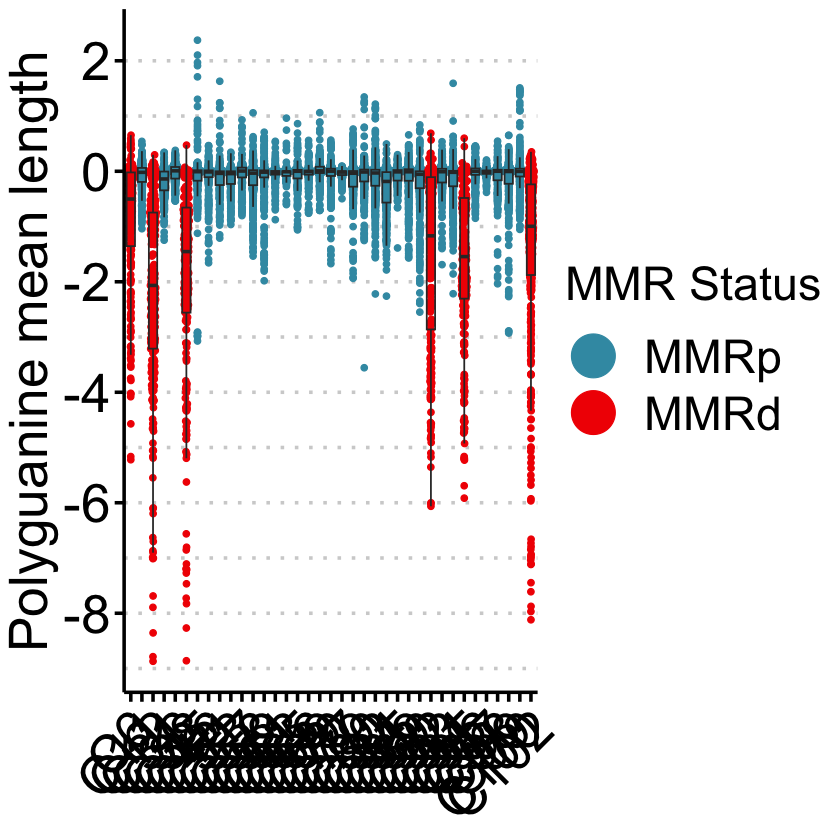

In [119]:
markerlengths %>%
    ungroup() %>%
    mutate(
        MSI = ifelse(subject %in% msi_samples$subject, TRUE, FALSE),
        subject = fct_relevel(subject, subjects)
    ) %>% 
    ggplot(aes(subject, length)) +
    geom_quasirandom(aes(color = MSI), width=0.3) +
    geom_boxplot(alpha = 0) +
    scale_y_continuous(breaks = seq(-10, 10, 2)) +
    scale_color_manual(
        values = c(wes_palette("Zissou1")[1], wes_palette("Zissou1")[5]),
        name = "MMR Status",
        labels = c("MMRp", "MMRd")
    ) +
    labs(y = "Polyguanine mean length") +
    theme_martin() +
    theme(
            axis.title.x = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1),
            panel.grid.major.y = element_line(linewidth = 1, color = "grey82", linetype = 3),
            panel.grid.minor.y = element_line(linewidth = 1, color = "grey82", linetype = 3),
            legend.key.height = unit(20, "pt"), legend.key.width = unit(20, "pt"), 
            legend.text = element_text(size = 28), legend.title = element_text(size=28)
      ) +
    guides(colour = guide_legend(override.aes = list(size=12)))
ggsave("../plots/Supplementary_figures/Supplementary_Fig5.pdf", height=11, width=22)

## Figure 1A

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


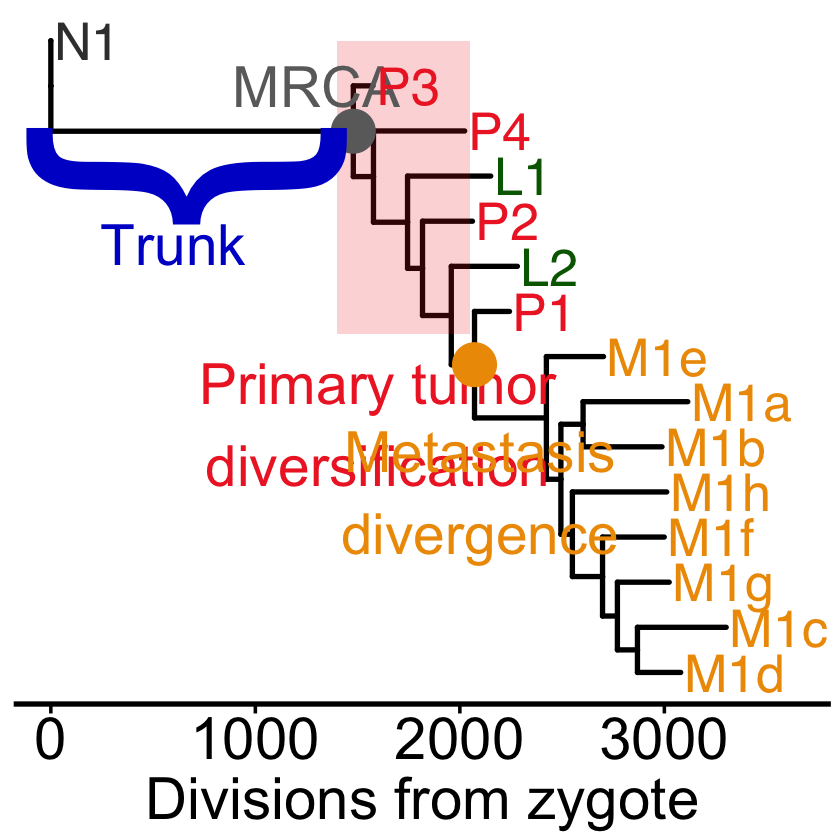

In [35]:
subject_i <- "C31"
c31_tree <- plot_tree(subject_i, l1_tbl)
subject_ggtree <- ggtree(c31_tree, size = 1.5) +
    theme_tree2() +
    labs(
      x = "Divisions from zygote"
    ) 

   # maximum y dimension for plotting
  max.y <- max(subject_ggtree$data$y)+1
  
  # maximum x dimension for plotting
  max.x <- max(subject_ggtree$data$x)*1.1
  
  # annotating the sample type
  subject_ggtree$data <- subject_ggtree$data %>%
      mutate(
          type = str_extract(label, "(?<=C[0-9]{1,3})[:alpha:]"),
          label = str_remove(label, subject_i)
      )
  subject_ggtree +
      # annotate primary tumor diversification
      annotate("rect", xmin = 1400, xmax = 2050, ymin = 1, ymax = 7.5, alpha = .2, fill = "firebrick2") +
      annotate("text", x = 1600, y = 9.5, label = "Primary tumor\ndiversification", color = "firebrick2", size = 12) +
      # annotate MRCA
      geom_nodepoint(data = . %>% filter(node == 29), size = 12, color = "grey42") +
      annotate("text", x = 1300, y = 2, label = "MRCA", color = "grey42", size = 12) +
      # annotate trunk
      annotate("text", x = 500, y = 4, label = "{", color = "blue3", size = 72, angle=90) +
      annotate("text", x = 600, y = 5.5, label = "Trunk", color = "blue3", size = 12) +
      # annotate metastasis divergence
      geom_nodepoint(data = . %>% filter(node == 24), size = 12, color = "orange2") +
      annotate("text", x = 2100, y = 11, label = "Metastasis\ndivergence", color = "orange2", size = 12) +
      # rest of the tree
      geom_tiplab(aes(color = type), size = 11, ) +
      scale_color_manual(
          values = c(A = "purple2", L = "darkgreen", M = "orange2", N = "grey23", P = "firebrick2"),
          guide = "none"
      ) +
    theme(
        axis.line.x = element_line(linewidth = 1.5),
        axis.title.x = element_text(size = 35, color = "black"),
        axis.text.x = element_text(size = 35, color = "black"),
        axis.ticks.x = element_line(color = "black", linewidth = 1),
        axis.ticks.length.x = unit(0.2, "cm"), plot.title = element_text(size = 35),
        axis.line.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    ) +
    xlim(0, max.x) +
    scale_y_reverse()

ggsave("../plots/Figure3/Fig3A.pdf", height=11, width=15)

# Cell division timing

Loading in clinical data

In [36]:
natgen_age <- read_xlsx("../data/Reiter_2020_Supplementary_Tables.xlsx", sheet=3,
                skip=1)  %>% 
    rename(subject = 2, age = 4, size = 16) %>%
    select(subject, age, size) %>%
    mutate(age = parse_number(age))    

New names:
* `` -> `...1`


In [38]:
science_age <-  read_xlsx("../data/Naxerova_2017_patient_information.xlsx") %>%
     rename(subject = Patient, size=`Tumor size`, age=`Age at dianosis`) %>%
     select(subject, age, size) %>% 
     filter(subject!="C57")

In [39]:
clinical_tbl <- bind_rows(science_age, natgen_age)

crc_l1_clinical <- l1_tbl %>%
    mutate(subject = str_extract(a, "C[0-9]{1,3}")) %>%
    left_join(clinical_tbl) 

crc_mrca_clinical <- mrca_tbl %>%
    select(subject, all_mrca, ad_ad_mrca) %>%
    pivot_longer(2:3, names_to = "tumor", values_to = "divs") %>% 
    left_join(clinical_tbl) 


Joining with `by = join_by(subject)`


Joining with `by = join_by(subject)`


Plotting MRCA divisions of cancers and adenomas:

Warning message:
"Removed 28 rows containing non-finite values (`stat_boxplot()`)."


Warning message:
"Removed 28 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 28 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 28 rows containing missing values (`geom_point()`)."


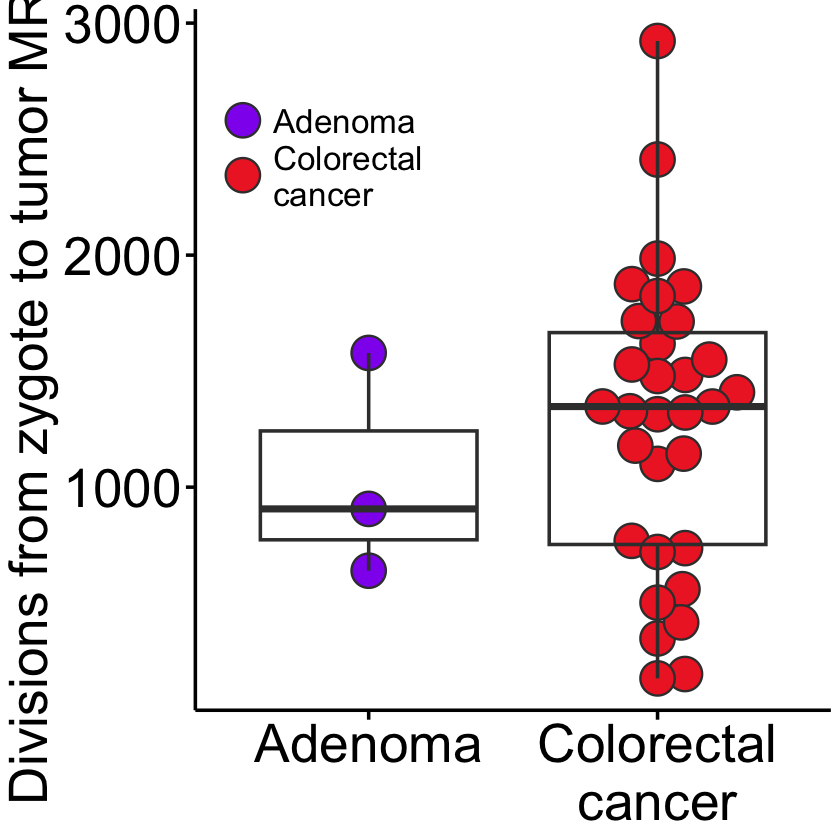

In [42]:
crc_mrca_clinical %>%
    filter((!subject %in% msi_tumors)) %>%
    ggplot(aes(tumor, divs)) +
    geom_beeswarm(aes(fill = tumor), shape=21, cex = 4.8, size = 9, color = "grey23", stroke = 1) +
    scale_fill_manual(labels=c("Adenoma", "Colorectal\ncancer"), values = c("purple2", "firebrick2"))  +
    geom_boxplot(alpha = 0, size = 1, color = "grey23") +
    scale_x_discrete(labels=c("Adenoma", "Colorectal\ncancer")) +
    labs(y="Divisions from zygote to tumor MRCA") +
    theme_martin() +
    theme(axis.title.x = element_blank(),
    legend.title = element_blank(), legend.text = element_text(size=20), legend.position = c(0.2, 0.8))
ggsave("../plots/Figure3/Fig3B.pdf", height=11, width=8)

Plotting age and divisions to MRCA:

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 28 rows containing missing values (`geom_point()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 28 rows containing missing values (`geom_point()`)."


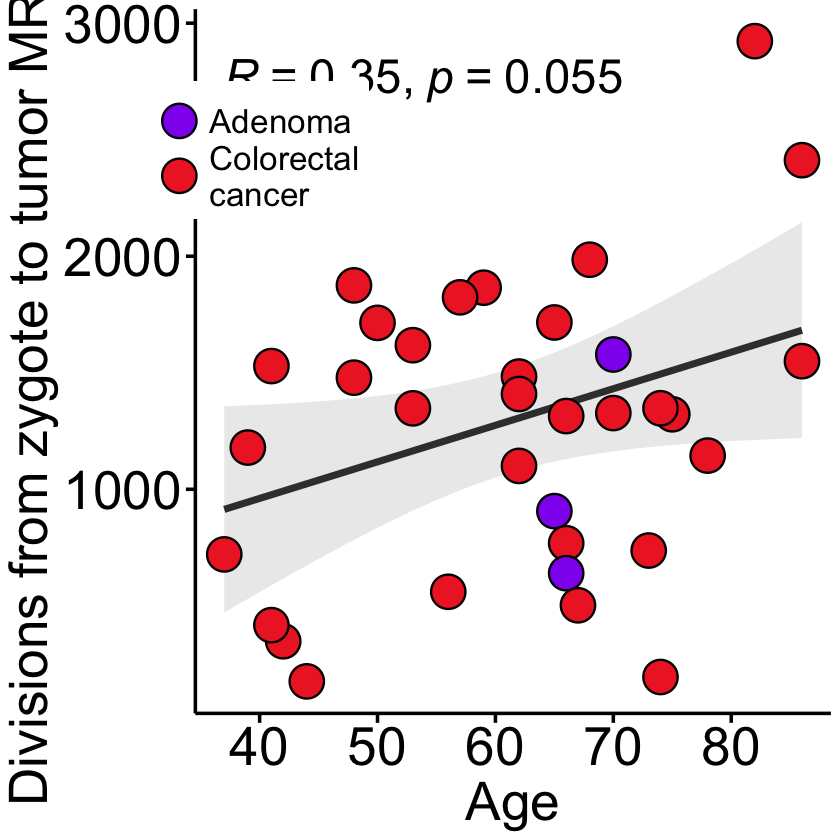

In [52]:
crc_mrca_clinical %>%
    filter(!(subject %in% msi_tumors)) %>%
    ggplot(aes(age, divs)) +
    geom_smooth(data = . %>% filter(tumor != "ad_ad_mrca"), method = "lm", size = 2, alpha = 0.2, color = "grey23") +
    geom_point(aes(fill = tumor), size = 9, pch = 21, stroke = 1) +
    scale_fill_manual(labels=c("Adenoma", "Colorectal\ncancer"), values = c("purple2", "firebrick2"))  +
    stat_cor(data=.%>% filter(tumor!="ad_ad_mrca"), size = 10, p.accuracy = 10e-4) +
    labs(x="Age", y="Divisions from zygote to tumor MRCA") +
    theme_martin() +
    theme(legend.title = element_blank(), legend.text = element_text(size=20), legend.position = c(0.1, 0.8))
ggsave("../plots/Figure3/Fig3C.pdf", height=11, width=14)

## Processing data from intestinal stem cell colonies

Markerlengths for the ISC colonies:

In [98]:
# directory of the results the colon ISCs used in Naxerova et al 2017.
dir_list <- list.files("../data/colon_iscs",
    pattern = "_R$", full.names = TRUE
)

l <- map(dir_list, get_markerlengths)
markerlengths_isc_raw  <- bind_rows(l)

P1947

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cols)

  # Now:
  data %>% select(all_of(cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."
STE0071

STE0072

STE0074

STE0076



Distance from the root needs to be subtracted manually, as the blood or bulk samples represent the germline genotype:

In [99]:
markerlengths_isc <- markerlengths_isc_raw %>%
    mutate(sample=str_sub(sample, end=-3)) %>% 
    group_by(subject, marker) %>%
    filter(any(str_detect(sample, "B"))) %>% 
    mutate(length = length - length[sample==str_subset(sample, "B")[1]]) %>% 
    ungroup

Getting the minimum number of marker all samples agree on, as long as that's more than 70% of the maximum possible markers 

In [100]:
get_minimum_marker_table  <- function(subject_i, markerlengths){

marker_tbl <-  markerlengths  %>% 
    filter(subject==subject_i)  %>% 
    group_by(sample)  %>% 
    add_count(sample)  %>% 
    ungroup()  %>% 
    mutate(minimum_markers = max(n)*0.7) %>% 
    filter(n>minimum_markers)  

samples <- unique(marker_tbl$sample)
marker_list <- lapply(samples, get_sampler_marker, marker_tbl)

common_markers  <- Reduce(intersect, marker_list)
n_common_markers  <- length(common_markers)

markerlengths %>%
    filter(subject == subject_i, marker %in% common_markers) %>%
    group_by(sample) %>%
    add_count(sample) %>%
    filter(n == n_common_markers) %>%
    select(-n) %>%
    mutate(markers=n_common_markers)
    
    }

In [101]:
# function to get markers that are present in all samples
get_sampler_marker  <- function(sample_i, marker_tbl) {

    marker_tbl  %>% 
    filter(sample==sample_i)  %>% 
    pull(marker)  %>% 
    unique()
}

In [102]:
# removing all markers that didn't amplify in 70% of the cases
subjects  <- unique(markerlengths_isc$subject)
minimum_marker_tbls  <- lapply(subjects, get_minimum_marker_table, markerlengths_isc)

Saving heatmaps with patient ages

In [103]:
create_heatmap_isc <- function(mean_lengths) {
    
    subject_i <- unique(mean_lengths$subject)

    age <-  case_when(
        str_detect(subject_i, "STE0071") ~ 4, str_detect(subject_i, "STE0072") ~ 4,
        str_detect(subject_i, "STE0076") ~ 9, str_detect(subject_i, "STE0074")~14, str_detect(subject_i, "P1947")~66
    ) 
    
    filtered_matrix <- mean_lengths %>% 
        mutate(sample = str_remove_all(sample, paste0(subject_i, "-"))) %>% 
        ungroup() %>% 
        select(-subject) %>% 
        pivot_wider(names_from = marker, 
        values_from = length) %>% 
        column_to_rownames("sample") %>%
        as.matrix()
    
    minmax <- max(abs(filtered_matrix), na.rm = TRUE)
    
    plot_title <- paste0("Donor: ", subject_i, " (", age, " years old)")

    hm <- pheatmap::pheatmap(filtered_matrix, clustering_distance_rows = "manhattan", 
        clustering_distance_cols = "manhattan", 
        display_numbers = TRUE, number_color = "black", fontsize = 6, 
        color = colorRampPalette(c("seagreen", "white", "purple3"))(42), 
        na_col = "yellow", breaks = seq(-minmax, minmax, length.out = 43), 
        silent = TRUE, main=plot_title)

    ggsave(paste0("../plots/Supplementary_figures/isc_hm/", subject_i, "_heatmap.pdf"), 
        hm, width = 10, height = 4)

}

In [104]:
isc_hm_tbls <- minimum_marker_tbls %>%
    map(\(x) select(x, -markers))

walk(isc_hm_tbls, create_heatmap_isc)

# Calculating L1 distance and cell divisions

Creating function to go through each sample separately

In [86]:
l1_cell_divs <- function(tbl) {
# find samples
samples <- tbl$sample %>% unique

combos_wide <- combn(samples, m= 2) %>% as.data.frame()

## make combo table longer
combos_long <- data.frame(a=as.character(combos_wide[1,]), b=as.character(combos_wide[2,]))

## only use combintions from the same subject
combos <- combos_long 
    
# getting l1 for all intrapatient sample combinations in the cohort
l1 <- lapply(1:nrow(combos), get_l1_r_for_combination, combos, tbl)

bind_rows(l1) %>%
    mutate(divs = l1 / 9.43139014888478e-05)
}


In [87]:
isc_divs_tbll1 <- map(minimum_marker_tbls, l1_cell_divs) %>%
    bind_rows()

Manually annotating from supplementary information of Naxerova et al 2017.


In [89]:
isc_l1 <- isc_divs_tbll1 %>%
    mutate(age = case_when(
        str_detect(a, "STE0071") ~ 4, str_detect(a, "STE0072") ~ 4,
        str_detect(a, "STE0076") ~ 9, str_detect(a, "STE0074")~14, str_detect(a, "P1947")~66
    )) %>% 
    filter(str_detect(a, "B")|str_detect(b, "B")) %>% 
    separate(a, c("subject", NA), "-") %>%
    select(subject, divs, age) %>%
    mutate(group="isc") 

Plotting days per division:

In [93]:
df_divs_stats <- crc_mrca_clinical %>%
  filter(!(subject %in% msi_tumors)) %>%
  filter(tumor=="all_mrca") %>% 
  select(subject, divs, age) %>%
  mutate(age=age-5, group="all_mrca") %>% 
  bind_rows(isc_l1) %>%
  drop_na() %>%
  mutate(divs_per_year=divs/age)  %>% 
  mutate(days_per_divs=365/divs_per_year)  %>%  
  filter(!is.na(days_per_divs))  %>% 
  group_by(group) %>% 
  mutate(
    n = n(),
    median = median(days_per_divs),
    mean = mean(days_per_divs),
    max = max(days_per_divs)
  ) %>% 
  ungroup() %>% 
  mutate(group = fct_relevel(group, "all_mrca", "isc"),
  group_num = as.numeric(fct_rev(group))) 

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


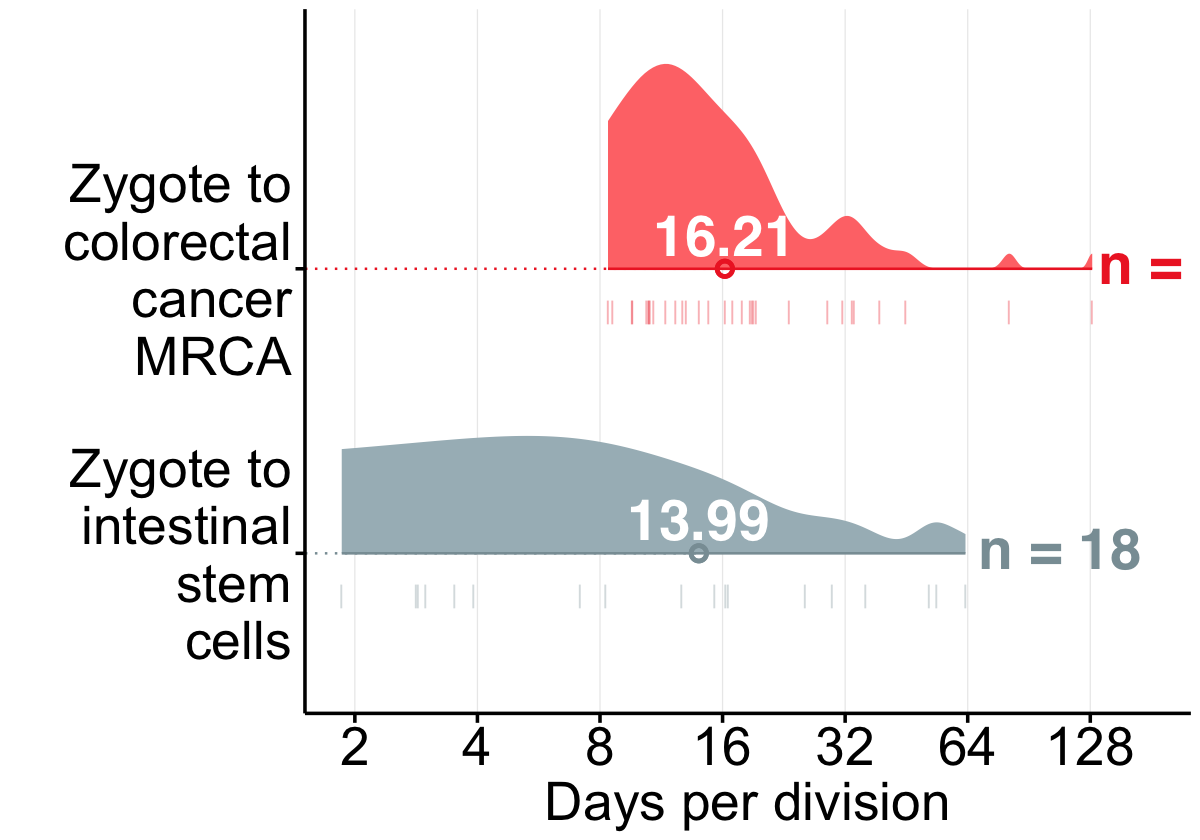

In [94]:
options(repr.plot.width=10, repr.plot.height=7)

ggplot(df_divs_stats, aes(days_per_divs, group_num, color = group)) +
  stat_summary(
    geom = "linerange",
    fun.min = function(x) -Inf,
    fun.max = function(x) median(x, na.rm = TRUE),
    linetype = "dotted",
    orientation = "y",
    size = .7
  ) +
  geom_point(
    aes(y = group_num - .15), 
    shape = "|",
    size = 5,
    alpha = .33
  ) +
  ggdist::stat_halfeye(
    aes(
      y = group_num,
      color = group,
      fill = after_scale(colorspace::lighten(color, .3))
    ),
    size=3,
    stroke=2,
    shape = 1,
    height = 0.8,
    point_size = 3,
    interval_size = 1.8,
    adjust = .59,
    .width = c(0, 1)
  )  +
  geom_text(
    aes(x = median, label = format(round(median, 2), nsmall = 2)),
    stat = "unique",
    color = "white",
    family = "Helvetica",
    fontface = "bold",
    size = 12,
    nudge_y = .12,
  ) +
  geom_text(
    aes(x = max, label = glue::glue("n = {n}")),
    stat = "unique",
    family = "Helvetica",
    fontface = "bold",
    size = 12,
    hjust = 0,
    nudge_x = 5,
    nudge_y = .02
  )  +
  coord_cartesian(clip = "off", expand = TRUE) +
  scale_y_continuous(
    limits = c(.55, NA),
    breaks = 1:2,
    labels = c("Zygote to\nintestinal\nstem\ncells", "Zygote to\ncolorectal\ncancer\nMRCA"),
  )  +
  scale_color_manual(values = c("all_mrca"="firebrick2", "isc"=wes_palette("Royal1")[1]),
                       guide="none") +
  scale_fill_manual(values = c("all_mrca"="firebrick2", "isc"=wes_palette("Royal1")[1]),
                       guide="none") +
  theme_martin() +
  coord_trans(x = "log2") +
  scale_x_continuous(breaks = breaks_log(8, base=2), expand = expansion(mult = 0, add = c(0.3, 0.75))) + 
  theme(
    panel.grid.major.x = element_line(size = .35),
    panel.grid.major.y = element_blank()
    ) +
    labs(x = "Days per division", y = "")
ggsave("../plots/Figure3/Fig3D.pdf", height=11, width=19)

## How often do samples divide after tumor initation?

In [9]:
science_cohort_timing <- read_excel("../data/Reiter_2020_Supplementary_Tables.xlsx", sheet = 1, skip = 1) %>%
    select(Patient, `Treatment between primary and distant metastasis resections`) %>%
    rename(subject = 1, timing = 2) %>%
    mutate(timing = ifelse(timing == "YES", "metachronous", "synchronous"))

natgent_cohort_timing <- read_excel("../data/Reiter_2020_Supplementary_Tables.xlsx", sheet = 3, skip = 1) %>%
    select(2, `Metachronous or synchronous (0-6 months) distant metastasis?`) %>%
    rename(subject = 1, timing = 2) %>%
    #C90 was manually reviewed to be synchronous
    mutate(timing=ifelse(subject=="C90", "synchronous", timing))

timing_tbl <- bind_rows(science_cohort_timing, natgent_cohort_timing) %>%
    drop_na()

meta_subjects <- timing_tbl %>%
    filter(timing == "metachronous") %>%
    pull(subject)

New names:
* `` -> `...1`
* `` -> `...12`
New names:
* `` -> `...1`


### Fig. 3E
Showing the time from cancer initation to each sample type:

In [7]:
tumor_ad_mrca <- long_mrca_tbl %>%
    select(-sample_type) %>% 
    filter(comparison == "all_mrca" | comparison == "ad_ad_mrca") %>%
    pivot_wider(names_from = "comparison", values_from="mrca_divs") %>% 
    rename(mrca_divs=all_mrca, ad_divs=ad_ad_mrca)

In [10]:
plot_divs_from_mrca <- tumor_ad_mrca %>%
       left_join(annotated_cmb_cell_divs) %>%
       group_by(subject) %>%
       filter((str_detect(a, "N") | str_detect(b, "N"))) %>%
       ungroup() %>%
       mutate(
              divs_from_mrca = ifelse(str_detect(a, "A") | str_detect(b, "A"), divs - ad_divs, divs - mrca_divs),
              sample_type = ifelse(type_a == "N", type_b, type_a)
       ) %>%
    filter(!((subject %in% meta_subjects) & sample_type == "M")) %>%
    mutate(sample_type = fct_relevel(sample_type, "A", "P", "L", "M"))

Joining with `by = join_by(subject)`


Kruskal Wallis test across all groups.

In [167]:
plot_divs_from_mrca %>%
    kruskal_test(divs_from_mrca ~ sample_type)

,.y.,n,statistic,df,p,method
,<chr>,<int>,<dbl>,<int>,<dbl>,<chr>
1,divs_from_mrca,399,31.73624,3,5.95e-07,Kruskal-Wallis


In [103]:
mrca_divs_pp <- plot_divs_from_mrca %>%
    filter(sample_type %in% c("A", "P")) %>%
    dunn_test(divs_from_mrca ~ sample_type) 

mrca_divs_lp <- plot_divs_from_mrca %>%
    filter(sample_type %in% c("L", "P")) %>%
    dunn_test(divs_from_mrca ~ sample_type) 

mrca_divs_mp <- plot_divs_from_mrca %>%
    filter(sample_type %in% c("M", "P")) %>%
    dunn_test(divs_from_mrca ~ sample_type) 

mrca_divs_p <- bind_rows(mrca_divs_pp, mrca_divs_lp, mrca_divs_mp) %>%
    mutate(group1 = fct_relevel(group1, "A", "P", "L", "M")) %>%
    adjust_pvalue() %>%
    add_xy_position(x = "sample_type") %>%
    p_format(accuracy = 1e-03, add.p = TRUE, digits = 2) %>%
    mutate(
        xmax = case_when(group2 == "L" ~ 3, group2 == "M" ~ 4, TRUE ~ xmax),
        y.position	 = case_when(group2 == "L" ~ 5968.966, group2 == "M" ~ 6468.966, TRUE ~ y.position)
    )

Warning message:
"There was 1 warning in `mutate()`.
i In argument: `group1 = fct_relevel(group1, "A", "P", "L", "M")`.
Caused by warning:
! 2 unknown levels in `f`: L and M"


In [104]:
mrca_divs_p

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif,y.position,groups,xmin,xmax
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<named list>,<dbl>,<dbl>
divs_from_mrca,A,P,13,183,0.9082904,p=0.364,p=0.364,ns,5432.785,"A, P",1,2
divs_from_mrca,P,L,183,130,2.4892589,p=0.013,p=0.026,*,5968.966,NULL,2,3
divs_from_mrca,P,M,183,69,5.3559898,p<0.001,p<0.001,****,6468.966,NULL,2,4


Warning message:
"Removed 4 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 4 rows containing missing values."
Warning message:
"Removed 4 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 4 rows containing missing values."


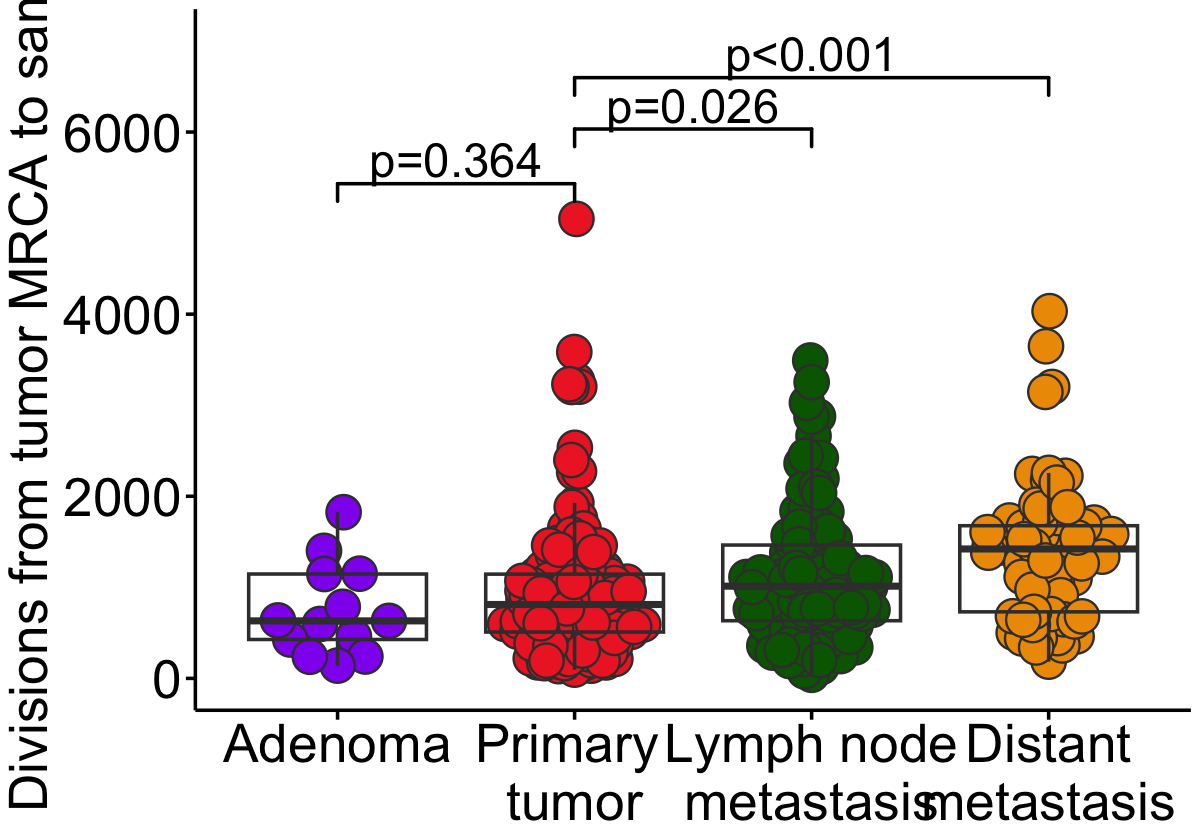

In [105]:
plot_divs_from_mrca %>%
    ggplot(aes(sample_type, divs_from_mrca)) +
    geom_quasirandom(aes(fill = sample_type), width = 0.3, size = 9, pch = 21, color = "grey23", stroke = 1) +
    geom_boxplot(alpha=0, size=1, color="grey23") +
    scale_fill_manual(values = c("A"="purple2", "L"="darkgreen", 
                                  "M"="orange2", "N"="grey23", "P"="firebrick2"),
                       guide="none") +
    stat_pvalue_manual(mrca_divs_p, label = "p.adj", tip.length = 0.03, step.increase = 0.01, size = 10, bracket.size = 1) +
    scale_x_discrete(labels=c("Adenoma", "Primary \ntumor", "Lymph node\nmetastasis", "Distant\nmetastasis")) +
    coord_cartesian(ylim=c(0,7000)) +
    labs(y="Divisions from tumor MRCA to sample") +
    theme_martin() +
    theme(axis.title.x = element_blank())

ggsave("../plots/Figure3/Fig3E.pdf", width=19, height=11)

## Fig 3F

Plotting individual trees

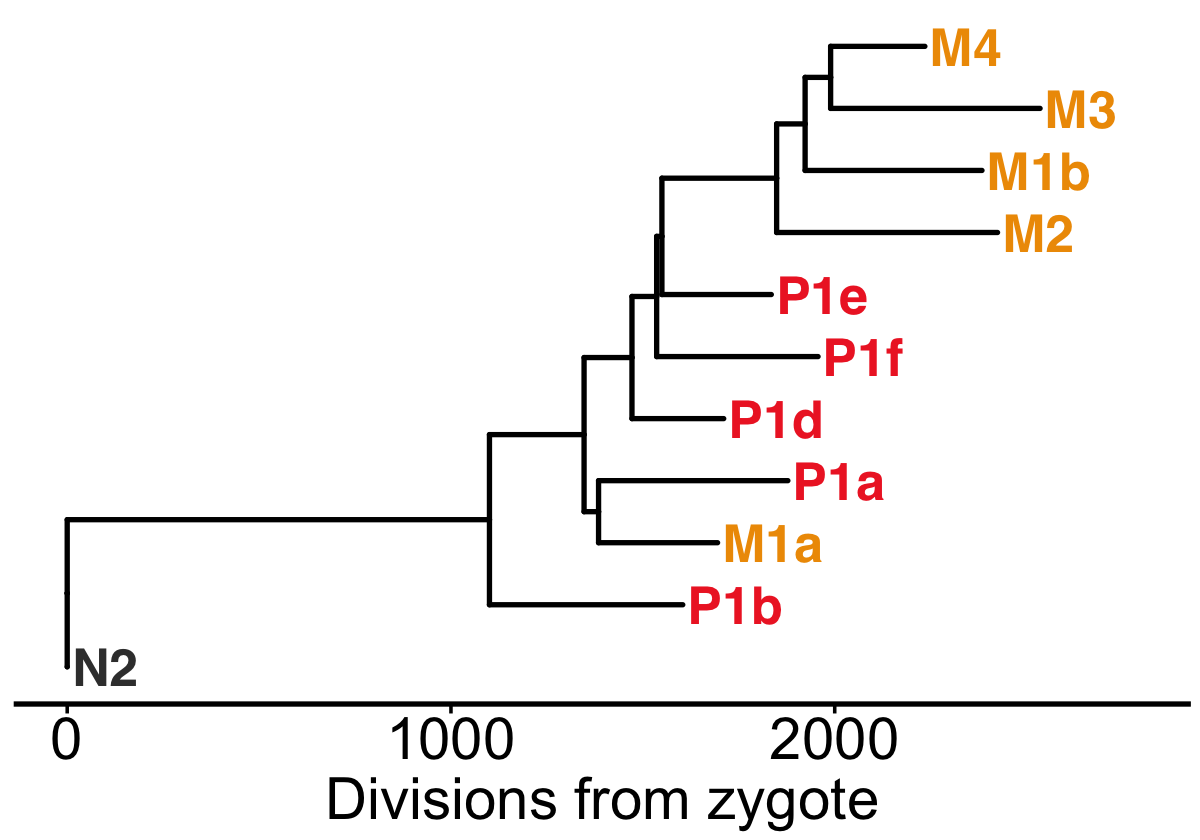

In [107]:
subject_i <- "C57"
tree <- plot_tree(subject_i, l1_tbl)
subject_ggtree <- ggtree(tree, size = 1.5) +
    theme_tree2() +
    labs(
      x = "Divisions from zygote"
    ) 

   # maximum y dimension for plotting
  max.y <- max(subject_ggtree$data$y)+1
  
  # maximum x dimension for plotting
  max.x <- max(subject_ggtree$data$x)*1.1
  
  # annotating the sample type
  subject_ggtree$data <- subject_ggtree$data %>%
      mutate(
          type = str_extract(label, "(?<=C[0-9]{1,3})[:alpha:]"),
          label = str_remove(label, subject_i)
      )
  
  subject_ggtree +
      geom_tiplab(aes(color = type), size = 11,  hjust = 0, shape = 21, fontface = 2) +
      scale_color_manual(
          values = c(A = "purple2", L = "darkgreen", M = "orange2", N = "grey23", P = "firebrick2"),
          guide = "none"
      ) +
    #geom_nodepoint(data=.%>% filter(node%in%c(13)), size=12,  fill="orange2", color="orange2") +
        theme(
            axis.line.x = element_line(linewidth = 1.5),
            axis.title.x = element_text(size = 35, color = "black"),
            axis.text.x = element_text(size = 35, color = "black"),
            axis.ticks.x = element_line(color = "black", linewidth = 1),
            axis.ticks.length.x = unit(0.2, "cm"), plot.title = element_text(size = 35),
            axis.line.y = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank()
        ) +
        xlim(0, max.x)

ggsave("../plots/Figure3/Fig3F.pdf", height=11, width=11)

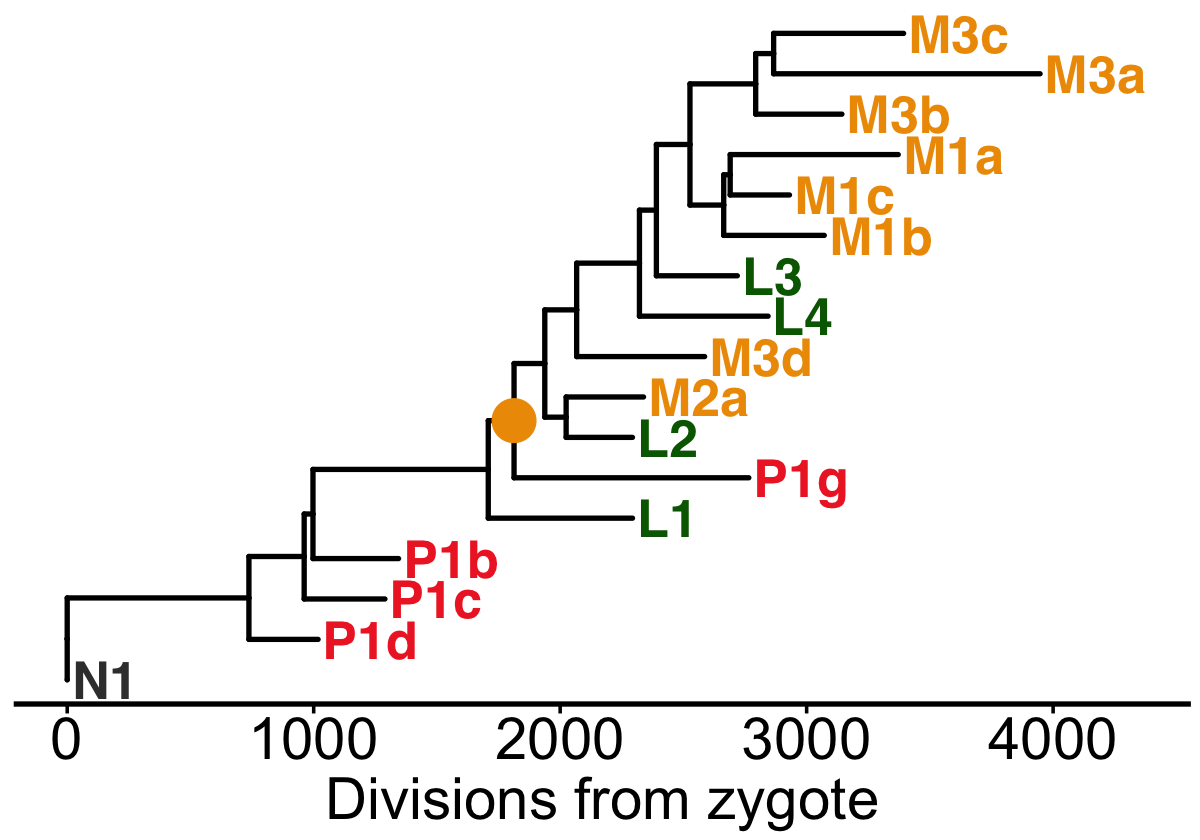

In [108]:
subject_i <- "C100"
tree <- plot_tree(subject_i, l1_tbl)
subject_ggtree <- ggtree(tree, size = 1.5) +
    theme_tree2() +
    labs(
      x = "Divisions from zygote"
    ) 

   # maximum y dimension for plotting
  max.y <- max(subject_ggtree$data$y)+1
  
  # maximum x dimension for plotting
  max.x <- max(subject_ggtree$data$x)*1.1
  
  # annotating the sample type
  subject_ggtree$data <- subject_ggtree$data %>%
      mutate(
          type = str_extract(label, "(?<=C[0-9]{1,3})[:alpha:]"),
          label = str_remove(label, subject_i),
      )
  
  subject_ggtree +
      #geom_tippoint(aes(color = type), color = "grey23", size = 11, nudge_x = -50, nudge_y = 0.2, angle = 45, hjust = 1, shape = 21, stroke = 1) +
      geom_tiplab(aes(color = type), size = 11,  hjust = 0, shape = 21, fontface = 2) +
      scale_color_manual(
          values = c(A = "purple2", L = "darkgreen", M = "orange2", N = "grey23", P = "firebrick2"),
          guide = "none"
      ) +
        geom_nodepoint(data = . %>% filter(node %in% c(29)), size = 12,  fill = "orange2", color = "orange2") +
        theme(
            axis.line.x = element_line(linewidth = 1.5),
            axis.title.x = element_text(size = 35, color = "black"),
            axis.text.x = element_text(size = 35, color = "black"),
            axis.ticks.x = element_line(color = "black", linewidth = 1),
            axis.ticks.length.x = unit(0.2, "cm"), plot.title = element_text(size = 35),
            axis.line.y = element_blank(),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank()
        ) +
        xlim(0, max.x)

ggsave("../plots/Figure3/Fig3G.pdf", height=11, width=11)

## Figure 3H
Metastasis private branches

In [68]:
# mrca of all samples
patient_mrca <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    select(-sample_type) %>%
    rename(divs = mrca_divs)

mrca_join_divg <- patient_mrca %>%
    select(-comparison) %>%
    rename(divs_to_mrca = divs)

# met divergence divisions 
met_sampled_div <- divergence_timing %>%
    filter(comparison == "met_primary") %>%
    mutate(sample_a = str_remove(samples, subject)) %>%
    select(-comparison) %>%
    rename(divs_to_divergence=mrca)

In [168]:
divs_from_divg_dm <- annotated_cmb_cell_divs %>%
    filter((str_detect(a, "N") & !str_detect(b, "N")) | (str_detect(b, "N") & !str_detect(a, "N"))) %>%
    mutate(comparison = ifelse(type_a == "N", type_b, type_a), sample_a = ifelse(str_detect(sample_a, "N"), sample_b, sample_a)) %>%
    left_join(met_sampled_div) %>%
    group_by(subject, comparison) %>% 
    left_join(mrca_join_divg) %>%
    mutate(
        across(c(divs, divs_to_divergence), ~ .x - divs_to_mrca), divs_after_divergence = divs-divs_to_divergence,
        fraction_to_divg = divs_to_divergence/divs
    ) %>% 
    mutate(divs = median(divs), divs_to_divergence = median(divs_to_divergence)) %>%
        filter(comparison %in% c("M", "P")) %>%
        group_by(subject) %>%
        fill(divs_to_divergence, .direction = "updown") %>%
        mutate(divs_after_divergence = divs - divs_to_divergence) %>%
        select(subject, divs_after_divergence, comparison) %>%
        distinct() %>%
        add_count() %>%
        filter(n == 2, !(subject %in% meta_subjects)) %>%
    mutate(comparison = fct_relevel(comparison, "P", "M")) 

Joining with `by = join_by(subject, sample_a)`


Joining with `by = join_by(subject)`


In [170]:
divs_from_divg_dm_p <- divs_from_divg_dm %>%
    ungroup %>% 
    wilcox_test(divs_after_divergence~comparison, paired = T) %>% 
        add_significance() %>%
    add_xy_position(x = "comparison") %>%
    mutate(y.position = y.position+50)  %>% 
    p_format(trailing.zero = TRUE, digits = 3, accuracy = 1e-03, add.p = TRUE) %>% 
    mutate(p=str_pad(p, 7, "0", side="right"))

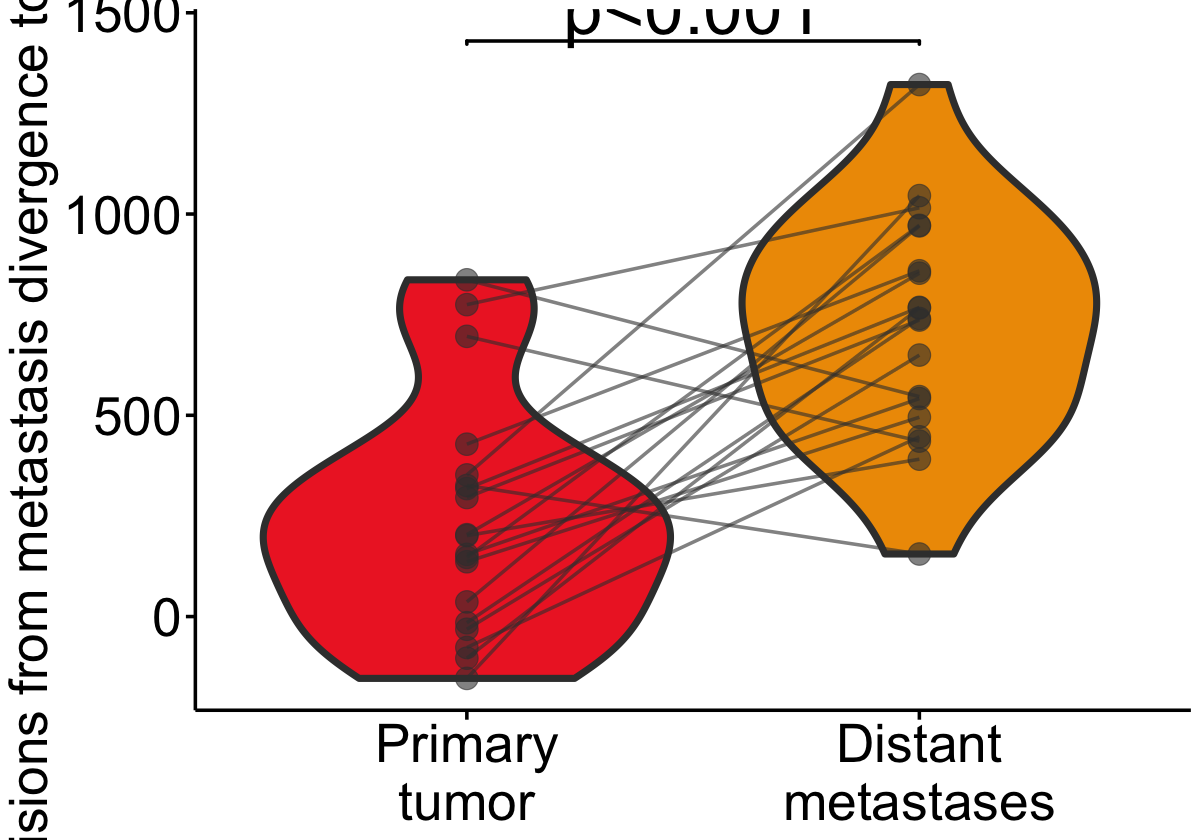

In [172]:
divs_from_divg_dm %>% 
    ggplot(aes(comparison, divs_after_divergence)) +
    geom_violin(aes(fill=comparison), 
                 size=2, color="grey23")+
    scale_fill_manual(
        values = c(
            "adenoma_adenoma" = "purple2", "L" = "darkgreen",
            "M" = "orange2", "N" = "grey23", "P" = "firebrick2"
        ),
        guide = "none"
    ) +
   geom_point(color = "grey23", alpha = 0.6, size = 6) +
   geom_line(aes(group = subject), color = "grey23", size = 1, alpha = 0.6) +
   stat_pvalue_manual(divs_from_divg_dm_p, label = "p", tip.length = 0.005, step.increase = 0.01, size = 15, bracket.size = 1) +
   scale_x_discrete(labels = c("Primary\ntumor", "Distant\nmetastases")) +
   labs(y = "Divisions from metastasis divergence to sample") +
   theme_martin() +
   theme(axis.title.x = element_blank())
ggsave("../plots/Figure3/Fig3H.pdf", height = 11, width = 11)

In [174]:
divs_from_divg_ln <- annotated_cmb_cell_divs %>%
    filter((str_detect(a, "N") & !str_detect(b, "N")) | (str_detect(b, "N") & !str_detect(a, "N"))) %>%
    mutate(comparison = ifelse(type_a == "N", type_b, type_a), sample_a = ifelse(str_detect(sample_a, "N"), sample_b, sample_a)) %>%
    left_join(met_sampled_div) %>%
    group_by(subject, comparison) %>%
    left_join(mrca_join_divg) %>%
    mutate(
        across(c(divs, divs_to_divergence), ~ .x - divs_to_mrca), divs_after_divergence = divs-divs_to_divergence,
        fraction_to_divg = divs_to_divergence/divs
    ) %>% 
    mutate(divs = median(divs), divs_to_divergence = median(divs_to_divergence)) %>%
        filter(comparison %in% c("L", "P")) %>%
        group_by(subject) %>%
        fill(divs_to_divergence, .direction = "updown") %>%
        mutate(divs_after_divergence = divs - divs_to_divergence) %>%
        select(subject, divs_after_divergence, comparison) %>%
        distinct() %>%
        add_count() %>%
        filter(n == 2) %>%
        mutate(comparison=fct_relevel(comparison,"P", "L"))

Joining with `by = join_by(subject, sample_a)`


Joining with `by = join_by(subject)`


In [177]:
divs_from_divg_ln_p <- divs_from_divg_ln %>%
    ungroup %>% 
    wilcox_test(divs_after_divergence~comparison, paired = T) %>% 
        add_significance() %>%
    add_xy_position(x = "comparison") %>%
    mutate(y.position = y.position+50)  %>% 
    p_format(trailing.zero = TRUE, digits = 3, accuracy = 1e-03, add.p = TRUE) %>% 
    mutate(p=str_pad(p, 7, "0", side="right"))

Warning message:
"Removed 2 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."
Warning message:
"Removed 2 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values (`geom_line()`)."


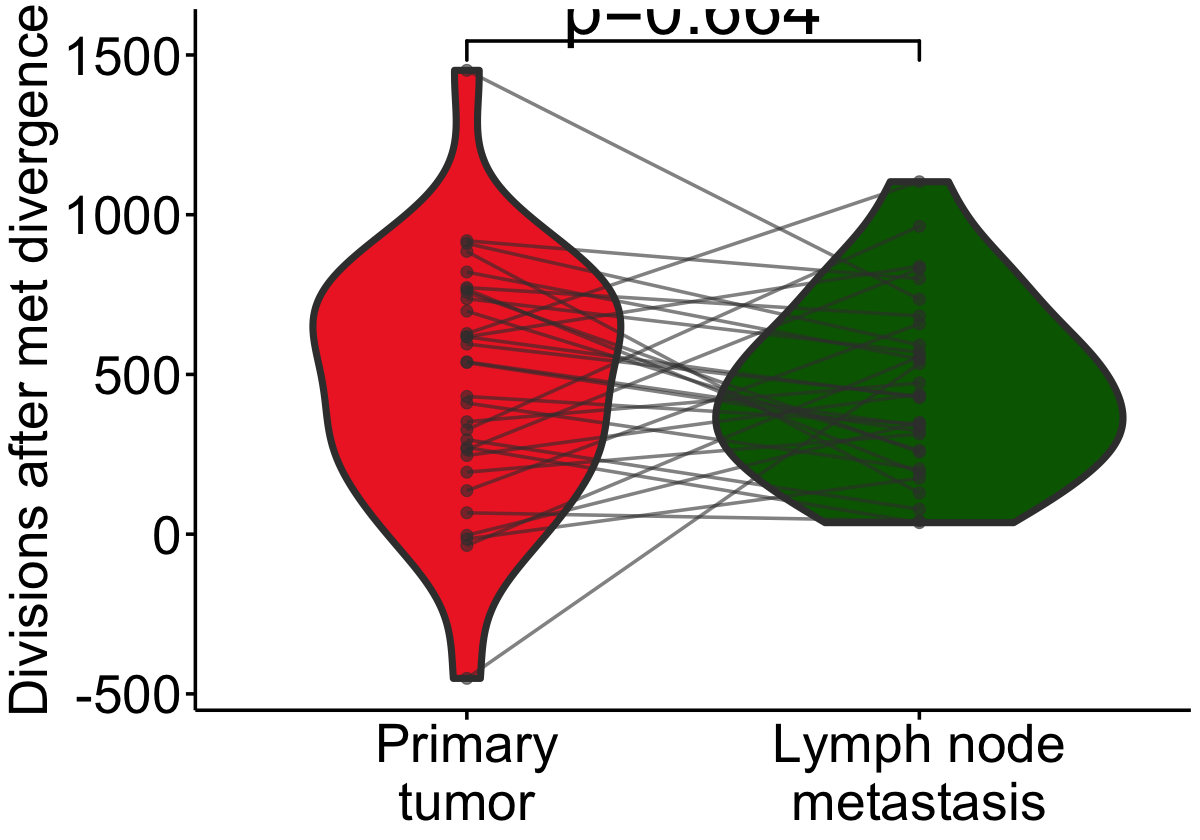

In [178]:
divs_from_divg_ln  %>% 
    ggplot(aes(comparison, divs_after_divergence)) +
    geom_violin(aes(fill=comparison), 
                 size=2, color="grey23")+
    scale_fill_manual(
        values = c(
            "adenoma_adenoma" = "purple2", "L" = "darkgreen",
            "M" = "orange2", "N" = "grey23", "P" = "firebrick2"
        ),
        guide = "none"
    ) +
    geom_point(color = "grey23", alpha = 0.6, size = 3) +
        geom_line(aes(group = subject), color = "grey23", size = 1, alpha = 0.6) +
        stat_pvalue_manual(divs_from_divg_ln_p, label = "p", tip.length = 0.03, step.increase = 0.01, size = 15, bracket.size = 1) +
        scale_x_discrete(labels = c("Primary\ntumor", "Lymph node\nmetastasis")) +
        labs(y = "Divisions after met divergence") +
        theme_martin() +
        theme(axis.title.x = element_blank())
ggsave("../plots/Figure3/Extended_Data_Fig2b.pdf", height = 11, width = 11)

# Fig 3I

In [69]:
divg_time_plot_data <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>% 
    filter(comparison != "adenoma_adenoma",!((subject %in% meta_subjects) & comparison=="met_primary")) %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) %>%
    ungroup() %>%
    mutate(comparison = fct_relevel(
        comparison,
        "primary_primary", "ln_primary", "met_primary"
    ))

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


In [189]:
p_pt_ln <- divg_time_plot_data %>%
    group_by(subject) %>%
    filter(comparison == "primary_primary" | comparison == "ln_primary") %>%
    add_count() %>%
    filter(n > 1) %>%
    ungroup() %>%
    mutate(comparison = as.character(comparison)) %>%
    wilcox_test(mrca ~ comparison, paired = T) 

p_pt_met <- divg_time_plot_data %>%
    group_by(subject) %>%
    filter(comparison == "primary_primary" | comparison == "met_primary") %>%
    add_count() %>%
    filter(n > 1) %>%
    ungroup() %>%
    mutate(comparison = as.character(comparison)) %>%
    wilcox_test(mrca ~ comparison, paired = T)

bind_rows(p_pt_ln, p_pt_met) %>%
    adjust_pvalue()


.y.,group1,group2,n1,n2,statistic,p,p.adj
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
mrca,ln_primary,primary_primary,31,31,319,0.169000,0.169000
mrca,met_primary,primary_primary,19,19,180,0.000164,0.000328


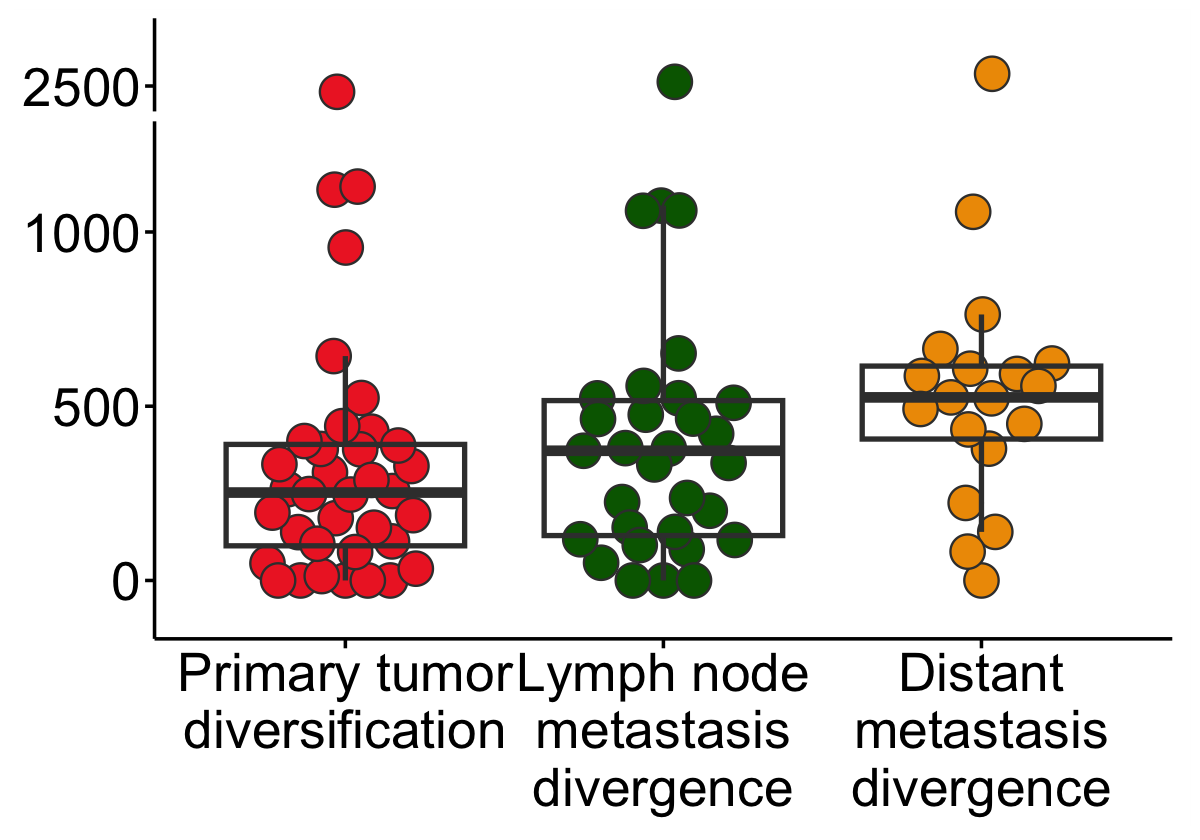

In [190]:
divg_time_plot_data %>% 
    ggplot(aes(comparison, mrca)) +
    geom_quasirandom(aes(fill = comparison), width = 0.3, size = 9, pch = 21, color = "grey23", stroke = 1, show.legend = FALSE) +
    geom_boxplot(alpha = 0, size = 1.5, color = "grey23") +
    scale_fill_manual(values = c(
        "primary_primary"="firebrick2",
        "ln_primary"="darkgreen",
        "met_primary"="orange2"),
                       guide="none") +
    scale_x_discrete(labels= c(
        "Primary tumor\ndiversification",
        "Lymph node\nmetastasis\ndivergence",
        "Distant\nmetastasis\ndivergence"
        )) +
    geom_point(aes(x = "met_primary", y = 3300), alpha = 0) +
    scale_y_break(c(1250, 2000), ticklabels = 2500, scales = 0.18, space = 0.01) +
    ylim(-100, 4000) +
    theme_martin() +
    theme(
        text = element_text(size = 20, color = "black"),
        axis.text = element_text(color = "black"),
        axis.ticks = element_line(color = "black"), axis.text.y.right = element_blank(), axis.ticks.y.right = element_blank(),
        axis.line.y.right = element_blank(), axis.title.y.left = element_blank(), axis.title.x = element_blank()
    ) 
ggsave("../plots/Figure3/Fig3I.pdf", height = 11, width = 11)

Comparing metachronous metastases separately

In [199]:
timing_p_ln <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(comparison != "adenoma_adenoma") %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) %>%
    ungroup() %>%
    filter(comparison != "met_primary") %>%
    group_by(subject) %>%
    add_count() %>%
    filter(n > 1) %>%
    ungroup() %>%
    wilcox_test(mrca ~ comparison, paired = T) 

timing_p_met <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(comparison != "adenoma_adenoma") %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) %>%
    ungroup() %>%
    filter(comparison != "ln_primary") %>%
    group_by(subject) %>%
    add_count() %>%
    filter(n > 1) %>%
    ungroup() %>%
    wilcox_test(mrca ~ comparison, paired = T) 

bind_rows(timing_p_ln, timing_p_met) %>%
    adjust_pvalue()

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.
Joining with `by = join_by(subject)`
`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


.y.,group1,group2,n1,n2,statistic,p,p.adj
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
mrca,ln_primary,primary_primary,31,31,319,0.169000,0.169000
mrca,met_primary,primary_primary,26,26,312,0.000217,0.000434


Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


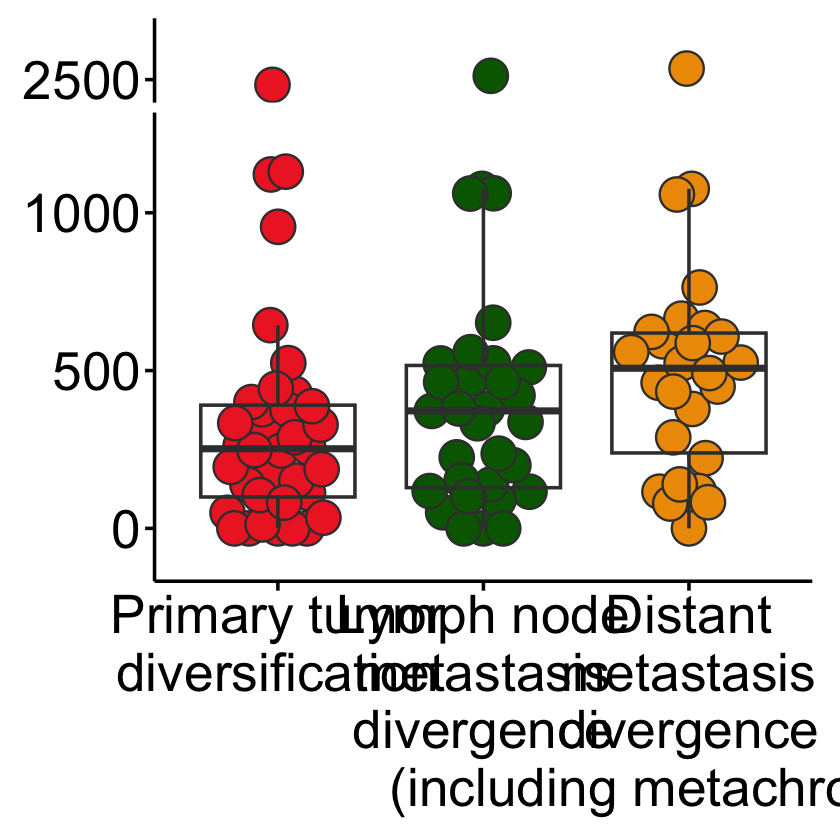

In [84]:
patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(comparison != "adenoma_adenoma") %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) %>%
    ungroup() %>%
    mutate(comparison = fct_relevel(
        comparison,
        "primary_primary", "ln_primary", "met_primary"
    )) %>%
    ggplot(aes(comparison, mrca)) +
    geom_quasirandom(aes(fill = comparison), width = 0.3, size = 9, pch = 21, color = "grey23", stroke = 1) +
    geom_boxplot(alpha = 0, size = 1, color = "grey23") +
    scale_fill_manual(values = c("A"="purple2", "ln_primary"="darkgreen", 
                                  "met_primary"="orange2", "M_meta"="orange3","N"="grey23", "primary_primary"="firebrick2"),
                       guide="none") +
    scale_x_discrete(labels= c(
        "Primary tumor\ndiversification",
        "Lymph node\nmetastasis\ndivergence",
        "Distant\nmetastasis\ndivergence\n(including metachronous)"
        )) + 
    scale_y_break(c(1250, 2000), ticklabels = 2500, scales = 0.18, space = 0.01) +
    ylim(-100, 4000) +
    theme_martin() +
    theme(
        text = element_text(size = 20, color = "black"),
        axis.text = element_text(color = "black"),
        axis.ticks = element_line(color = "black"), axis.text.y.right = element_blank(), axis.ticks.y.right = element_blank(),
        axis.line.y.right = element_blank(), axis.title.y.left = element_blank(), axis.title.x = element_blank()
    ) +
        labs(y="Divisions from MRCA") 
ggsave("../plots/Figure3/Extended_Data_Fig2d.pdf", height = 11, width = 14)

## Extended Data Fig 1
Bootstrapping key steps of cancer evolution on the patient level.

In [120]:
# generated in sample processing step
l <- readRDS("../results/bootstrapped_crc_trees.rds")

Cancer MRCA of all cases

In [121]:
extract_mrca_fast <- function(tree){
  
  # finding the mrca of all tumor samples
  tumors <-  c(str_subset(tree$tip.label, "N|Ad", negate = TRUE))
  findMRCA(tree, tumors, type = "height")
 
}

In [122]:
mrca_numbers <- l %>%
    list_flatten() %>%
    purrr::map(extract_mrca_fast)

In [123]:
subjects_bs <- unique(markerlengths$subject)

In [124]:
mrca_bootstraps <- tibble(x = unlist(mrca_numbers))
subject_mrca_bootstraps <- tibble(x = unlist(mrca_numbers), subject=rep(subjects_bs, each=1000)) 

In [125]:
observed_mrcas <- mrca_tbl %>%
    select(1:2)
cohort_mrca_median <- median(observed_mrcas$all_mrca)

Joining with `by = join_by(subject)`


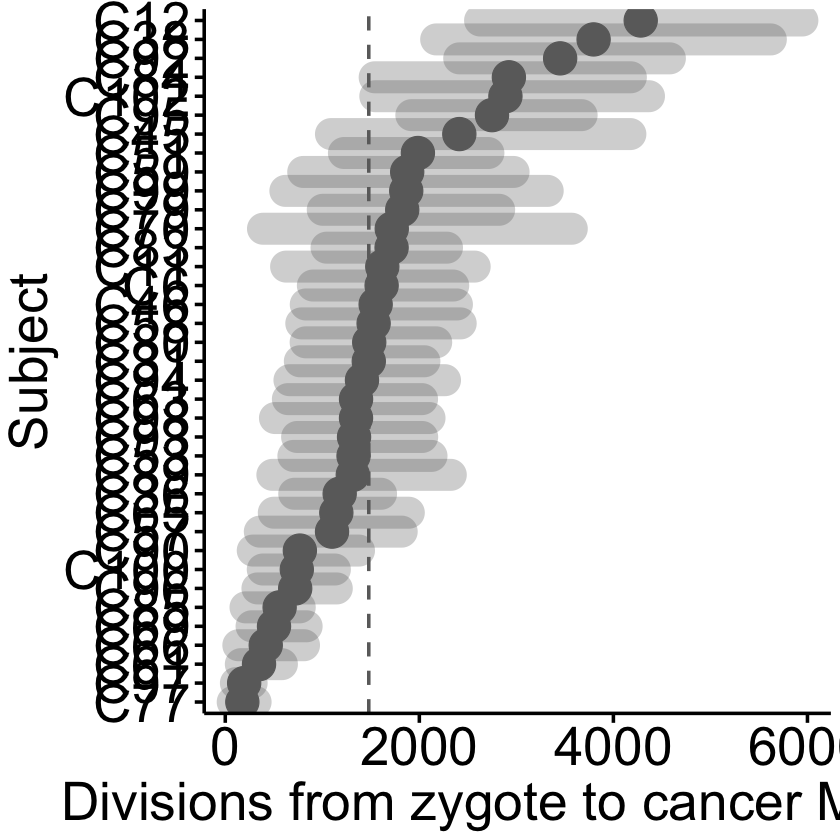

In [126]:
subject_mrca_bootstraps %>%
    group_by(subject) %>%
    summarize(median = median(x), twofive = quantile(x, 0.025), ninesevenfive = quantile(x, 0.975)) %>%
    left_join(observed_mrcas) %>% 
    ggplot(aes(all_mrca, reorder(subject, median))) +
    geom_segment(aes(x = twofive, xend = ninesevenfive, y = reorder(subject, all_mrca), yend = reorder(subject, all_mrca)), lineend = "round", size = 9, alpha = 0.3, color = "grey42") +
    geom_point(size = 9, color = "grey42") +
    geom_vline(xintercept = cohort_mrca_median, linetype = 2, color = "grey42", size = 1) +
    labs(y = "Subject", x = "Divisions from zygote to cancer MRCA") +
    theme_martin()
ggsave("../plots/Figure3/Extended_Data_Fig1a.pdf", height = 20, width = 17)

Primary tumor diversification

In [50]:
timing_pt_divergence <- function(tree) {
  
  # find unique lesions 
  unique_lesions <- tree$tip.label %>% 
    str_remove("[:alpha:]$") %>% 
    str_subset("M|L") %>% 
    unique()

  # finding the mrca of all tumor samples
  tumors <-  c(str_subset(tree$tip.label, "N|Ad", negate = TRUE))
  all_mrca <-  findMRCA(tree, tumors, type = "height")
  
  met_primary_mrca <- lapply(unique_lesions, get_lesion_primary_mrca_dist, tree)
  
  # all primary tumor samples
  p_samples <- tree$tip.label %>%
    str_subset("P")
  
 primary_primary_mrca <- NULL 
 if (length(p_samples) > 1) {
   # all unique combinations of primary tumor samples
   cbm <- combn(p_samples, m = 2) %>% as.data.frame()

   primary_primary_mrca <- lapply(1:ncol(cbm), get_primary_primary_mrca_dist, cbm, tree)
  }

  return(bind_rows(primary_primary_mrca, met_primary_mrca) %>%
    mutate(mrca = mrca-all_mrca))
 
}

In [51]:
flat <- l %>%
    list_flatten()

In [58]:
landmark_timings <- flat %>%
    parallel::mclapply(timing_pt_divergence) 

In [59]:
names(landmark_timings) <- paste0(rep(subjects_bs, each=1000), "_", rep(1:1000, 37))

In [60]:
landmarkts_tbl <- list_rbind(landmark_timings, names_to = "subject")

In [62]:
landmarkts_tbl %>%
    write_tsv("../results/bootstrapped_landmark_tbl.tsv")

In [85]:
# patient median divergence timing
pat_med_divg <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(comparison != "adenoma_adenoma") %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) 

Joining with `by = join_by(subject)`
`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


In [66]:
summary_tbl <- landmarkts_tbl %>%
    # C63 only has one sample of the primary tumor, so there is no ground truth in terms of divergence timing
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>% 
    separate(subject, c("subject", "rep")) %>%
    filter(subject != "C63") %>% 
    group_by(subject, rep, comparison) %>%
    summarize(divs = median(mrca)) %>%
    group_by(subject, comparison) %>%
    summarize(median = median(divs), twofive = quantile(divs, 0.025), ninesevenfive = quantile(divs, 0.975))

`summarise()` has grouped output by 'subject', 'rep'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


Primary tumor diversification

In [87]:
pt_divs_tbl <- pat_med_divg %>%
    filter(comparison == "primary_primary") %>%
    rename(pt_divs=mrca)
pt_divs_median <- median(pt_divs_tbl$pt_divs)

Joining with `by = join_by(subject, comparison)`


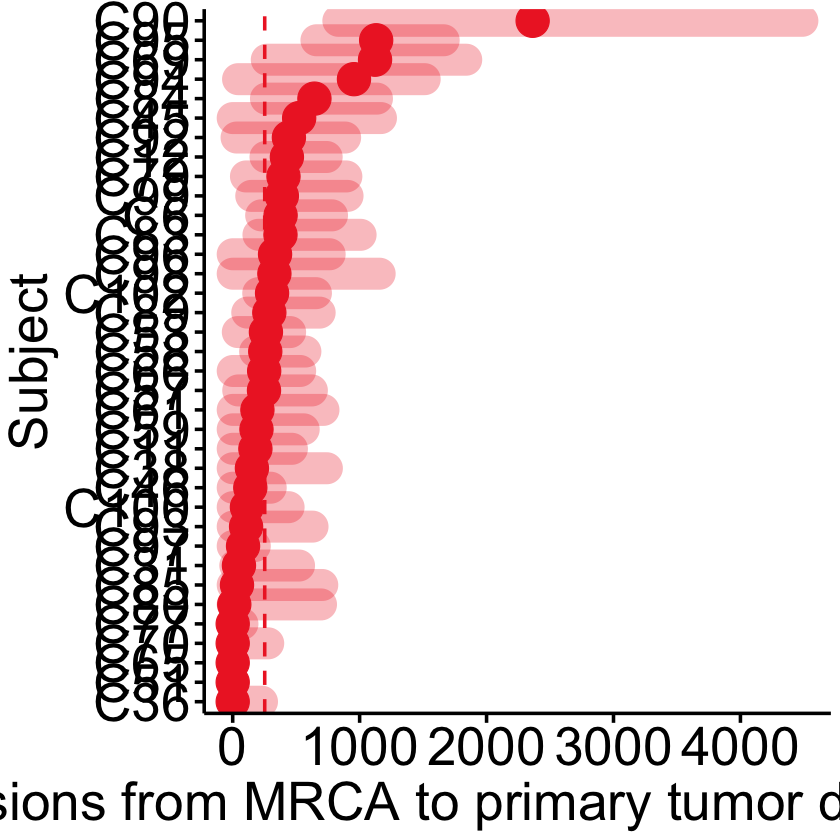

In [127]:
summary_tbl %>%
    filter(comparison == "primary_primary") %>%
    left_join(pt_divs_tbl) %>% 
    ggplot(aes(pt_divs, reorder(subject, pt_divs))) +
    geom_segment(aes(x = twofive, xend = ninesevenfive, y = reorder(subject, pt_divs), yend = reorder(subject, pt_divs)), lineend = "round", size = 9, alpha = 0.3, color = "firebrick2") +
    geom_point(size = 9, color = "firebrick2") +
    geom_vline(xintercept = pt_divs_median, linetype = 2, color = "firebrick2", size = 1) +
    labs(y = "Subject", x = "Divisions from MRCA to primary tumor diversification") +
    theme_martin()
ggsave("../plots/Figure3/Extended_Data_Fig1b.pdf", height = 20, width = 17)

Distant metastasis divergence

In [89]:
met_divs_tbl <- pat_med_divg %>%
    filter(comparison == "met_primary") %>%
    rename(met_divs=mrca)
met_divs_median <- median(met_divs_tbl$met_divs)

Joining with `by = join_by(subject, comparison)`


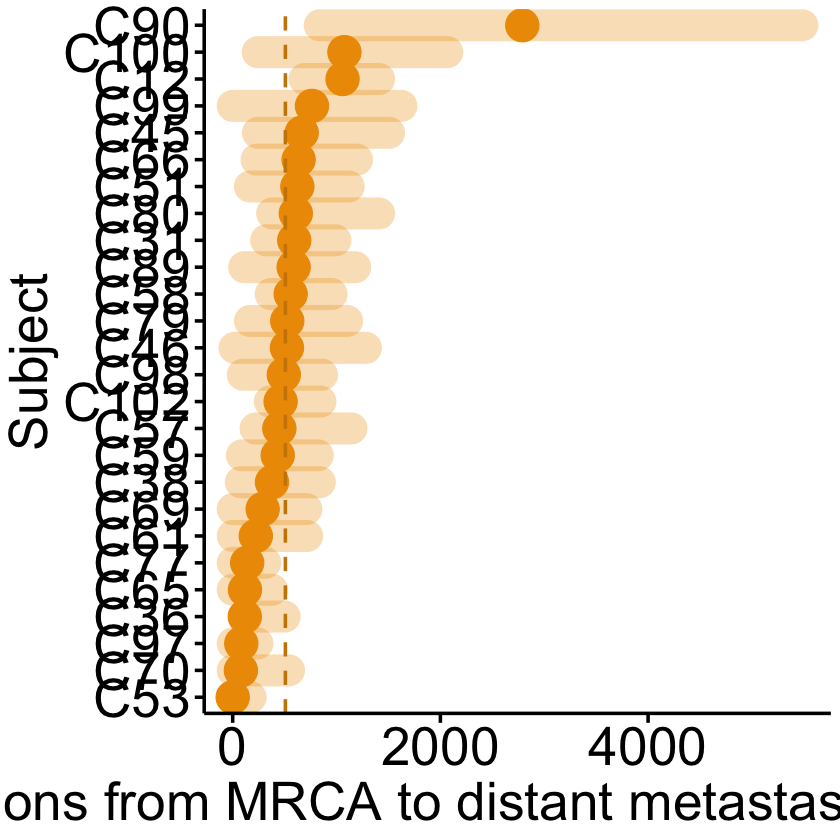

In [128]:
summary_tbl %>%
    filter(comparison == "met_primary") %>%
    left_join(met_divs_tbl) %>% 
    ggplot(aes(met_divs, reorder(subject, met_divs))) +
    geom_segment(aes(x = twofive, xend = ninesevenfive, y = reorder(subject, met_divs), yend = reorder(subject, met_divs)), lineend = "round", size = 9, alpha = 0.3, color = "orange2") +
    geom_point(size = 9, color = "orange2") +
    geom_vline(xintercept = met_divs_median, linetype=2, color = "orange3", size=1) +
    labs(y="Subject", x="Divisions from MRCA to distant metastasis divergence") +
    theme_martin()
ggsave("../plots/Figure3/Extended_Data_Fig1d.pdf", height = 20, width = 17)

Lymph node metastasis divergence

In [93]:
ln_divs_tbl <- pat_med_divg %>%
    filter(comparison == "ln_primary") %>%
    rename(ln_divs = mrca)
ln_divs_median <- median(ln_divs_tbl$ln_divs)

Joining with `by = join_by(subject, comparison)`


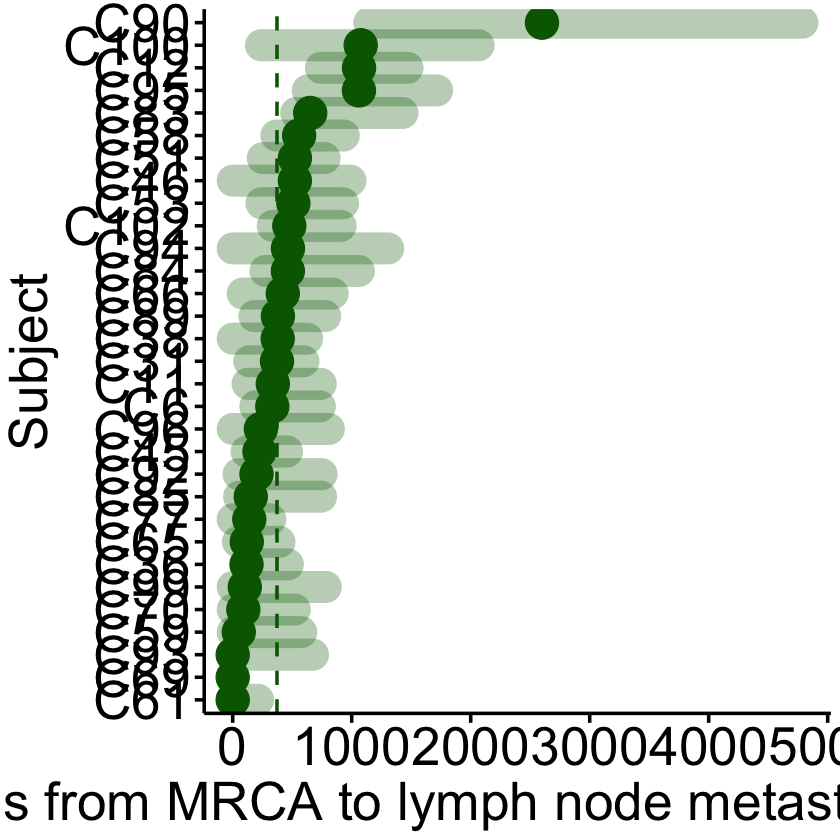

In [129]:
summary_tbl %>%
    filter(comparison == "ln_primary") %>%
    left_join(ln_divs_tbl) %>% 
    ggplot(aes(ln_divs, reorder(subject, ln_divs))) +
    geom_segment(aes(x = twofive, xend = ninesevenfive, y = reorder(subject, ln_divs), yend = reorder(subject, ln_divs)), lineend = "round", size = 9, alpha = 0.3, color = "darkgreen") +
    geom_point(size = 9, color = "darkgreen") +
    geom_vline(xintercept = ln_divs_median, linetype = 2, color = "darkgreen", size = 1) +
    labs(y = "Subject", x = "Divisions from MRCA to lymph node metastasis divergence") +
    theme_martin()
ggsave("../plots/Figure3/Extended_Data_Fig1c.pdf", height = 20, width = 17)

## Fig 3J
Divisions of primary tumor sample clostest to mets

In [305]:
# excluding early seeding events
early_seeding <- divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    group_by(subject, comparison) %>%
    summarize(mrca = median(mrca)) %>%
    mutate(mrca = mrca - mrca[comparison == "primary_primary"]) %>%
    filter(comparison == "met_primary", mrca < 0) %>%
    pull(subject)

# finding the primary tumor samples that have the smallest distance to any met sample
min_met_dist_sample <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    left_join(annotated_cmb_cell_divs) %>%
    filter((str_detect(a, "P") & str_detect(b, "M")) | (str_detect(b, "P") & str_detect(a, "M"))) %>%
    mutate(met_lesion = ifelse(str_detect(sample_a, "M"), sample_a, sample_b)) %>% 
    group_by(subject, met_lesion) %>% 
    slice_min(divs) %>% 
    mutate(min_met_dist_sample = ifelse(str_detect(a, "P"), a, b)) %>% 
    pull(min_met_dist_sample)

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


Joining with `by = join_by(subject)`


In [306]:
seeding_region_tbl <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    left_join(annotated_cmb_cell_divs) %>%
    group_by(subject) %>%
    filter((str_detect(a, "N") | str_detect(b, "N"))) %>%
    filter(str_detect(a, "P") | str_detect(b, "P")) %>%
    mutate(divs_from_mrca = divs - mrca_divs, met_adjacent = ifelse(a %in% min_met_dist_sample | b %in% min_met_dist_sample, TRUE, FALSE)) %>%
    group_by(subject, met_adjacent) %>%
    summarize(divs_from_mrca = median(divs_from_mrca)) %>%
    group_by(subject) %>%
    filter(n() == 2) %>%
    ungroup() %>%
    filter(!(subject %in% early_seeding)) 

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


In [307]:
paired_p <- seeding_region_tbl %>%
    wilcox_test(divs_from_mrca ~ met_adjacent, paired = T) %>%
    add_xy_position(x = "met_adjacent") %>%
    mutate(y.position = 3500)  %>% 
    p_format(trailing.zero = TRUE, digits = 3, accuracy = 1e-03, add.p = TRUE) %>% 
    mutate(p=str_pad(p, 7, "0", side="right"))
paired_p

.y.,group1,group2,n1,n2,statistic,p,y.position,groups,xmin,xmax
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>
divs_from_mrca,FALSE,TRUE,24,24,79,p=0.0425,3500,"FALSE, TRUE",1,2


In [308]:
seeding_medians <- seeding_region_tbl %>%
    group_by(met_adjacent) %>%
    summarise(divs_from_mrca = median(divs_from_mrca)) %>% 
    mutate(met_adjacent = ifelse(met_adjacent, "adjacent", "not_adjacent"), met_adjacent = fct_relevel(met_adjacent, "not_adjacent", "adjacent"))

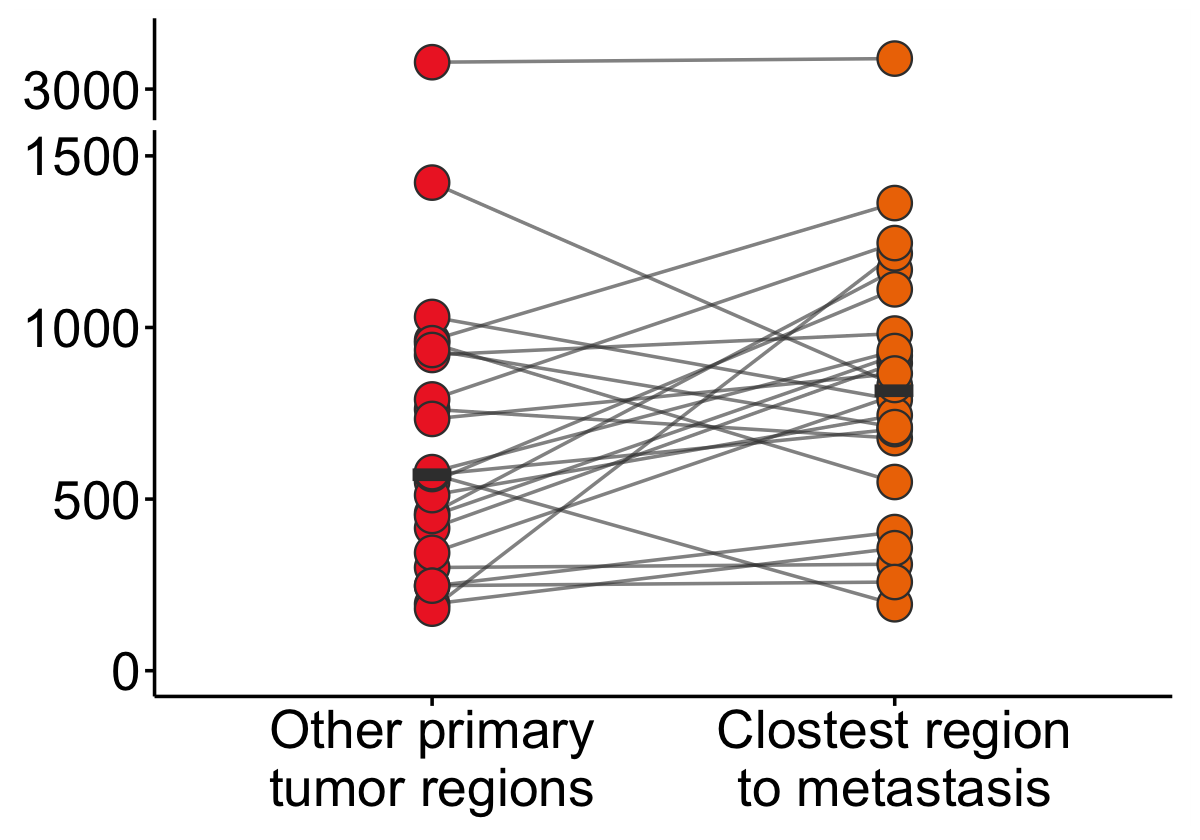

In [215]:
seeding_region_tbl %>%
    mutate(met_adjacent = ifelse(met_adjacent, "adjacent", "not_adjacent"), met_adjacent = fct_relevel(met_adjacent, "not_adjacent", "adjacent")) %>%
    ggplot(aes(met_adjacent, divs_from_mrca)) +
    geom_line(aes(group = subject), color = "grey23", size = 1, alpha = 0.6) +
    geom_point(aes(fill = met_adjacent), size = 9, pch = 21, color = "grey23", stroke = 1, show.legend = FALSE) +
    geom_point(data=seeding_medians, color="grey23", shape="-", size=30) +
    scale_y_break(c(1500, 2800), ticklabels = 3000, scales = 0.18, space = 0.01) +
    ylim(0, 3500) +
    scale_fill_manual(
        values = c(
            "adjacent" = "darkorange2", "not_adjacent" = "firebrick2"
        ),
        guide = "none"
    ) +
    scale_x_discrete(labels = c("Other primary\ntumor regions", "Clostest region\nto metastasis")) +
        labs(y = "Divisions from MRCA") +
        theme_martin() +
        theme(axis.title.x = element_blank(), axis.title.y = element_blank(),  axis.title.y.right  = element_blank(),
            axis.text.y.right  = element_blank(), axis.ticks.y.right  = element_blank(), axis.line.y.right  = element_blank())
ggsave("../plots/Figure3/Fig3J.pdf", height = 11, width = 11)

Same analysis for lymph node metastases:

In [218]:
# excluding early seeding events
early_seeding_ln <- divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    group_by(subject, comparison) %>%
    summarize(mrca = median(mrca)) %>%
    mutate(mrca = mrca - mrca[comparison == "primary_primary"]) %>%
    filter(comparison == "ln_primary", mrca < 0) %>%
    pull(subject)

# finding the primary tumor samples that have the smallest distance to any met sample
min_met_dist_sample_ln <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    left_join(annotated_cmb_cell_divs) %>%
    filter((str_detect(a, "P") & str_detect(b, "L")) | (str_detect(b, "P") & str_detect(a, "L"))) %>%
    mutate(met_lesion = ifelse(str_detect(sample_a, "L"), sample_a, sample_b)) %>% 
    group_by(subject, met_lesion) %>% 
    slice_min(divs) %>% 
    mutate(min_met_dist_sample = ifelse(str_detect(a, "P"), a, b)) %>% 
    pull(min_met_dist_sample)

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


Joining with `by = join_by(subject)`


In [221]:
seeding_region_tbl_ln <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    left_join(annotated_cmb_cell_divs) %>%
    group_by(subject) %>%
    filter((str_detect(a, "N") | str_detect(b, "N"))) %>%
    filter(str_detect(a, "P") | str_detect(b, "P")) %>%
    mutate(divs_from_mrca = divs - mrca_divs, met_adjacent = ifelse(a %in% min_met_dist_sample_ln | b %in% min_met_dist_sample_ln, TRUE, FALSE)) %>%
    group_by(subject, met_adjacent) %>%
    summarize(divs_from_mrca = median(divs_from_mrca)) %>%
    group_by(subject) %>%
    filter(n() == 2) %>%
    ungroup() %>%
    filter(!(subject %in% early_seeding_ln)) 

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


In [222]:
paired_p <- seeding_region_tbl_ln %>%
    wilcox_test(divs_from_mrca ~ met_adjacent, paired = T) %>%
    add_xy_position(x = "met_adjacent") %>%
    mutate(y.position = 3500)  %>% 
    p_format(trailing.zero = TRUE, digits = 3, accuracy = 1e-03, add.p = TRUE) %>% 
    mutate(p=str_pad(p, 7, "0", side="right"))
paired_p

.y.,group1,group2,n1,n2,statistic,p,y.position,groups,xmin,xmax
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>
divs_from_mrca,FALSE,TRUE,18,18,104,p=0.442,3500,"FALSE, TRUE",1,2


In [223]:
seeding_medians_ln <- seeding_region_tbl_ln %>%
    group_by(met_adjacent) %>%
    summarise(divs_from_mrca = median(divs_from_mrca)) %>% 
    mutate(met_adjacent = ifelse(met_adjacent, "adjacent", "not_adjacent"), met_adjacent = fct_relevel(met_adjacent, "not_adjacent", "adjacent"))

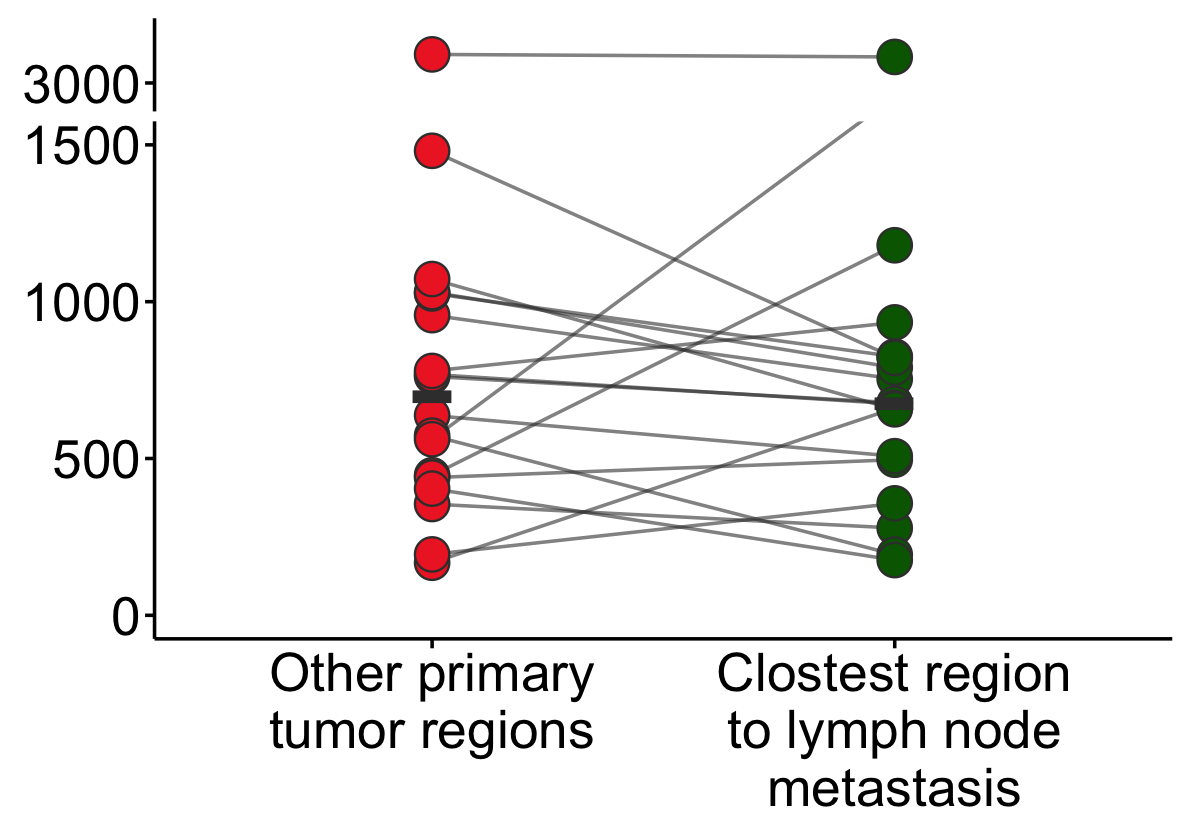

In [226]:
seeding_region_tbl_ln %>%
    mutate(met_adjacent = ifelse(met_adjacent, "adjacent", "not_adjacent"), met_adjacent = fct_relevel(met_adjacent, "not_adjacent", "adjacent")) %>%
    ggplot(aes(met_adjacent, divs_from_mrca)) +
    geom_line(aes(group = subject), color = "grey23", size = 1, alpha = 0.6) +
    geom_point(aes(fill = met_adjacent), size = 9, pch = 21, color = "grey23", stroke = 1, show.legend = FALSE) +
    geom_point(data=seeding_medians_ln, color="grey23", shape="-", size=30) +
    scale_y_break(c(1500, 2800), ticklabels = 3000, scales = 0.18, space = 0.01) +
    ylim(0, 3500) +
    #stat_pvalue_manual(paired_p, label = "p", tip.length = 0.005, step.increase = 0.01, size = 15, bracket.size = 1) +
    scale_fill_manual(
        values = c(
            "adjacent" = "darkgreen", "not_adjacent" = "firebrick2"
        ),
        guide = "none"
    ) +
    scale_x_discrete(labels = c("Other primary\ntumor regions", "Clostest region\nto lymph node\nmetastasis")) +
        labs(y = "Divisions from MRCA") +
        theme_martin() +
        theme(axis.title.x = element_blank(), axis.title.y = element_blank(),  axis.title.y.right  = element_blank(),
            axis.text.y.right  = element_blank(), axis.ticks.y.right  = element_blank(), axis.line.y.right  = element_blank())
ggsave("../plots/Figure3/Extended_Data_Fig2f.pdf", height = 11, width = 11)

## Timing when metastases could have diverged

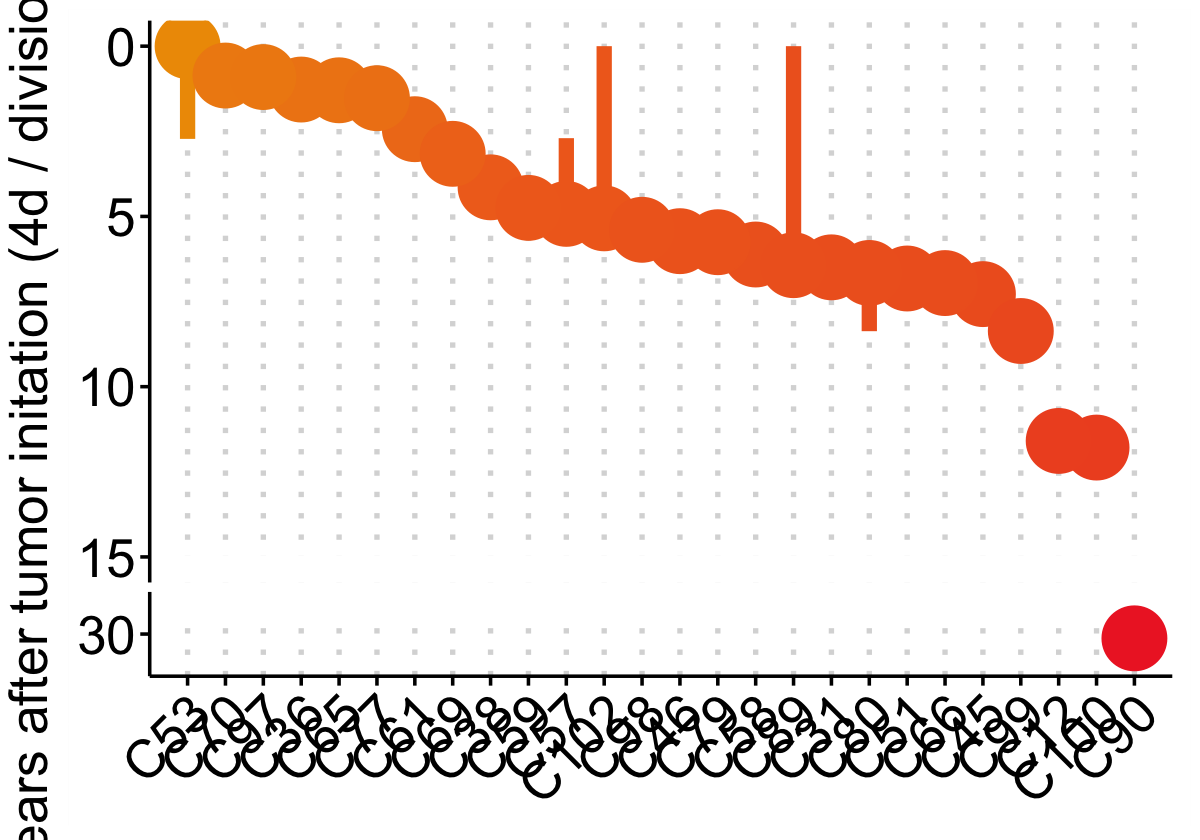

In [233]:
divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(str_detect(comparison, "met")) %>%
    left_join(patient_mrca, by=c("subject")) %>%
    mutate(
        mrca_diff = mrca - divs,
        years_from_mrca = mrca_diff / 91.25
    ) %>%
    group_by(subject) %>%
    summarize(min = min(years_from_mrca), max = max(years_from_mrca), years_from_mrca = median(years_from_mrca)) %>%
    ggplot(aes(reorder(subject, years_from_mrca), years_from_mrca)) +
    geom_hline(yintercept = 16, color="white", size=20) +
    geom_hline(yintercept = 24, color="white", size=20) +
    geom_pointrange(aes(ymin = min, ymax = max, group = subject, color = log2(years_from_mrca + 1)), size = 4.3,
    linewidth=4.3,
    show.legend = FALSE) +
    scale_colour_gradient(low = "orange2", high = "firebrick2") +
    scale_y_break(c(15, 25),  ticklabels=c(30), scales=0.15) +
    scale_y_reverse(
       "Years after tumor initation (4d / division)",
       limits=c(35,0)
     ) +
    scale_x_discrete(expand = expansion(mult = 0, add = 1)) +
    theme_martin() +
    theme(axis.title.x = element_blank(), axis.text.x = element_text(angle=45, hjust=1),
    panel.grid.major.x = element_line(size=1.5, color="grey85", linetype = 3), axis.title.y.right  = element_blank(),
            axis.text.y.right  = element_blank(), axis.ticks.y.right  = element_blank(), axis.line.y.right  = element_blank())
    ggsave("../plots/Figure3/Extended_Data_Fig2g.pdf", height = 11, width = 24)

Years from cancer MRCA to metastasis divergence

In [108]:
tumor_mrca <- long_mrca_tbl %>%
    filter(comparison=="all_mrca") %>% 
    select(subject, mrca_divs)

In [95]:
divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(str_detect(comparison, "met")) %>%
    left_join(tumor_mrca) %>%
    mutate(
        mrca_diff = mrca - mrca_divs,
        years_from_mrca = mrca_diff / 91.25
    ) %>%
    group_by(subject) %>%
    summarize(min = min(years_from_mrca), max = max(years_from_mrca), years_from_mrca = median(years_from_mrca)) %>% 
    summarize(min(years_from_mrca), max(years_from_mrca), median(years_from_mrca))

Joining with `by = join_by(subject)`


min(years_from_mrca),max(years_from_mrca),median(years_from_mrca)
<dbl>,<dbl>,<dbl>
0,30.5586,5.559582


In [110]:
# finding number of division from tumor MRCA to median of primary samples
# works as a surrogate for cell divisions at diagnosis
diag_divs <- tumor_ad_mrca %>%
    left_join(annotated_cmb_cell_divs) %>%
    group_by(subject) %>%
    filter((str_detect(a, "N") & str_detect(b, "P")) | str_detect(a, "P") & str_detect(b, "N")) %>%
    mutate(divs_from_mrca=divs-mrca_divs) %>% 
    summarize(pt_divs_from_mrca=median(divs_from_mrca))

Joining with `by = join_by(subject)`


In [111]:
divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(str_detect(comparison, "met")) %>%
    left_join(tumor_mrca) %>%
    mutate(
        mrca_diff = mrca - mrca_divs,
        years_from_mrca = mrca_diff / 91.25
    ) %>%
    group_by(subject) %>%
        summarize(min = min(years_from_mrca), max = max(years_from_mrca), years_from_mrca = median(years_from_mrca), mrca_diff = median(mrca_diff)) %>%
        left_join(diag_divs) %>%
        mutate(divs_before_diag = pt_divs_from_mrca - mrca_diff, years_before_diag = divs_before_diag / 91.25) %>%
        summarize(min(years_before_diag),max(years_before_diag),median(years_before_diag))

Joining with `by = join_by(subject)`
Joining with `by = join_by(subject)`


min(years_before_diag),max(years_before_diag),median(years_before_diag)
<dbl>,<dbl>,<dbl>
-4.94797,12.74962,2.304485


# Fig 3K

In [257]:
# mrca of all samples
median_mrca_tbl <- long_mrca_tbl %>%
    filter(comparison == "all_mrca") %>%
    filter(!(subject %in% msi_tumors)) %>%
    select(-sample_type) %>%
    rename(divs = mrca_divs) %>%
    group_by(comparison) %>%
    summarize(divs=median(divs))

median_mrca <- median_mrca_tbl$divs

# primary and adenoma diversification + met and ln divergence
divg_med_tbl <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarise(divs = median(mrca)) %>% 
    summarise(divs = median(divs)) %>% 
    filter(comparison!="adenoma_adenoma") %>% 
    drop_na()

# divs from zygote to sample type
divs_to_sample_med_tbl <- plot_divs_from_mrca %>%
    rename(comparison=sample_type) %>% 
    group_by(comparison) %>%
    summarise(divs = median(divs_from_mrca))

Joining with `by = join_by(subject)`
`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


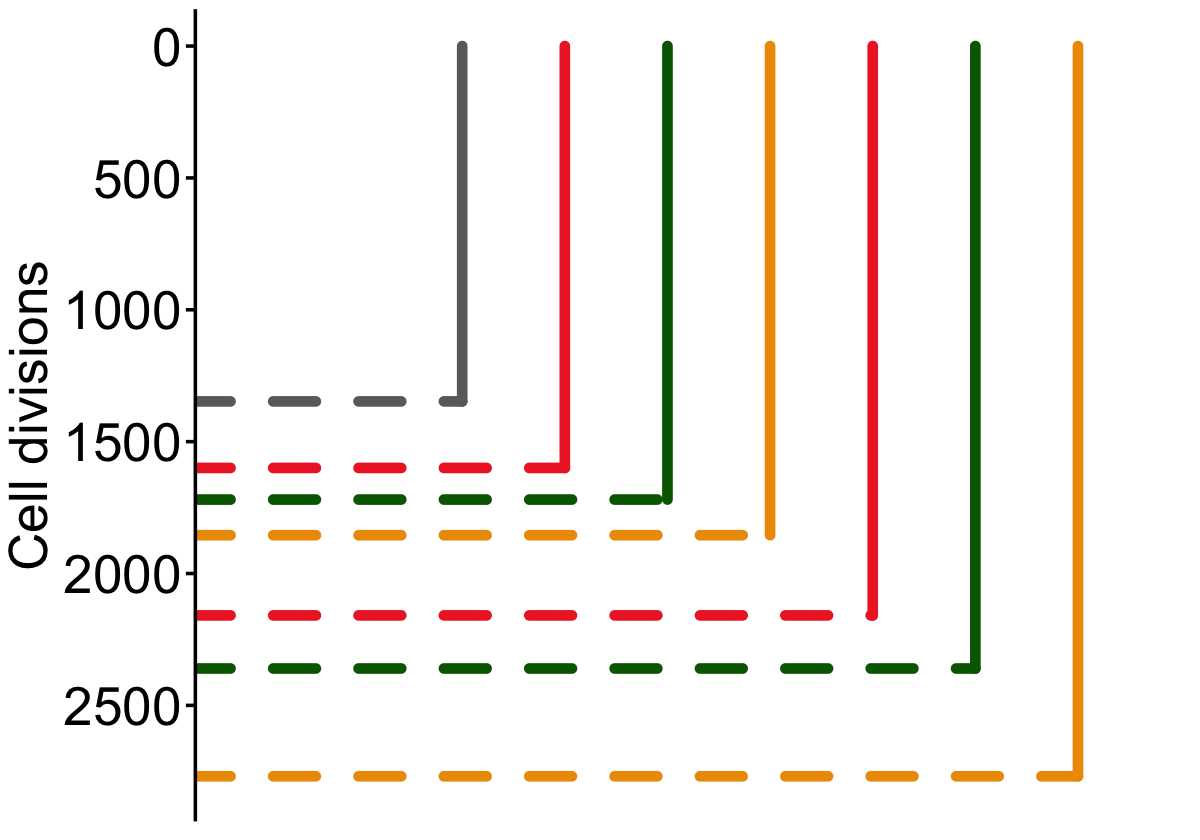

In [258]:
bind_rows(median_mrca_tbl, divg_med_tbl, divs_to_sample_med_tbl) %>%
    mutate(divs = ifelse(comparison != "all_mrca", divs + divs[comparison == "all_mrca"], divs)) %>%
    drop_na() %>% 
    mutate(comparison = fct_reorder(comparison, divs)) %>%
    ggplot(aes(comparison, divs, color = comparison)) +
    geom_segment(aes(x = comparison, xend = comparison, y = 0, yend = divs), size = 3, lineend = "round") +
    geom_segment(aes(x = -5, xend = comparison, y = divs, yend = divs), size = 3, lineend = "round", linetype = 2) +
    scale_color_manual(
        values = c(
            "L" = "darkgreen", "ln_primary" = "darkgreen",
            "M" = "orange2", "met_primary" = "orange2", "all_mrca" = "grey42",
            "P" = "firebrick2", "primary_primary" = "firebrick2"
        ),
        guide = "none"
    ) +
    scale_y_continuous(breaks=seq(0,3000, 500)) +
    coord_cartesian(ylim = c(2800, 0), xlim=c(-1,7.5)) +
    labs(y = "Cell divisions") +
    theme_martin() +
    theme(
        axis.line.x = element_blank(), axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
    )
ggsave("../plots/Figure3/Fig3K.pdf", height = 20, width = 16)

## Numbers for the text

Number of MMRd and MMRp samples

In [266]:
msi_samples <- markerlengths %>%
    group_by(subject) %>%
    mutate(large_del = (length < (-1))) %>%
    count(large_del) %>%
    mutate(del_frac = n / sum(n)) %>%
    filter(large_del, del_frac > 0.1)
msi_samples %>%
    nrow()
37 - 6

[1] 6

[1] 31

Sample numbers for first paragraph:

In [267]:
# all samples
n_distinct(c(l1_tbl %>%
    pull(a), l1_tbl %>%
    pull(b)))

[1] 505

In [268]:
sample_number <- function(type) {
    n_distinct(c(l1_tbl %>%
    pull(a), l1_tbl %>%
    pull(b)) %>% 
        str_subset(type)
    )
}

In [269]:
#normal samples
sample_number("N")

[1] 73

In [270]:
#adenomas
sample_number("Ad")

[1] 17

In [271]:
#primary tumor
sample_number("P")

[1] 183

In [272]:
#LN mets
sample_number("L")

[1] 130

In [273]:
#distant mets
sample_number("M")

[1] 102

In [274]:
# tumor samples
sample_number("Ad") + sample_number("P")+sample_number("L")+sample_number("M")

[1] 432

Cell divisions to cancer MRCA

In [275]:
mrca_tbl %>%
    filter(!(subject %in% msi_tumors)) %>%
    summarise(median(all_mrca), sd(all_mrca))

median(all_mrca),sd(all_mrca)
<dbl>,<dbl>
1347.414,639.5609


Cell divisions to adenoma MRCA

In [276]:
mrca_tbl %>%
    summarise(median(ad_ad_mrca, na.rm = T), sd(ad_ad_mrca, na.rm = T))

"median(ad_ad_mrca, na.rm = T)","sd(ad_ad_mrca, na.rm = T)"
<dbl>,<dbl>
906.2799,483.6381


ISC donor ages

In [277]:
min(c(4, 4, 9, 14, 66))
max(c(4, 4, 9, 14, 66))

[1] 4

[1] 66

Divisions since tumor MRCA per sample type. Only synchronous distant metastases.

In [278]:
plot_divs_from_mrca %>%
    group_by(sample_type) %>%
    summarise(median(divs_from_mrca, na.rm = TRUE), sd(divs_from_mrca, na.rm = TRUE))

sample_type,"median(divs_from_mrca, na.rm = TRUE)","sd(divs_from_mrca, na.rm = TRUE)"
<fct>,<dbl>,<dbl>
A,631.6603,502.4743
P,811.3547,691.2512
L,1012.7399,703.4256
M,1421.4491,748.3837


Divergence and diversification timing from cancer MRCA

In [280]:
patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarise(divs = median(mrca)) %>% 
    summarise(median(divs, na.rm=T), sd=sd(divs, na.rm=T)) 

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


comparison,"median(divs, na.rm = T)",sd
<chr>,<dbl>,<dbl>
adenoma_adenoma,-128.6973,430.5136
ln_primary,372.1827,498.2519
met_primary,507.3118,534.7928
primary_primary,252.2611,449.4946
NA,NA,NA


Patients with metastasis divergence before primary tumor diversification.

In [289]:
met_divg_class <- patient_mrca %>%
    select(-comparison) %>%
    left_join(divergence_timing) %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    filter(comparison != "adenoma_adenoma") %>%
    mutate(mrca = mrca - divs) %>%
    group_by(comparison, subject) %>%
    summarize(mrca = median(mrca)) %>%
    ungroup() %>%
    mutate(comparison = fct_relevel(
        comparison,
        "primary_primary", "ln_primary", "met_primary"
    )) %>%
    group_by(subject) %>%
        filter(comparison != "ln_primary") %>%
        filter(n() == 2) %>%
        mutate(mrca = mrca - mrca[comparison == "primary_primary"])
    

# early divergence
met_divg_class %>%
    filter(mrca < 0, comparison == "met_primary") %>%
    nrow()
# late divergence
met_divg_class %>%
    filter(mrca >= 0,  comparison=="met_primary") %>%
    nrow()

Joining with `by = join_by(subject)`


`summarise()` has grouped output by 'comparison'. You can override using the
`.groups` argument.


[1] 2

[1] 24

In [290]:
24/26*100

[1] 92.30769

Division times of metastases seeding primary tumor regions:

Numbers for last paragraph of section for Fig 3

In [126]:
pt_mrca_ln_met_divg <- divergence_timing %>%
    mutate(comparison = ifelse(str_detect(samples, "L"), "ln_primary", comparison)) %>%
    group_by(subject, comparison) %>%
    summarize(divs = median(mrca))

# divs from zygote to sample type
divs_to_sample <- annotated_cmb_cell_divs %>%
    filter((str_detect(a, "N") & !str_detect(b, "N")) | (str_detect(b, "N") & !str_detect(a, "N"))) %>%
    mutate(comparison = ifelse(type_a == "N", type_b, type_a)) %>%
    select(subject, comparison, divs) %>% 
    group_by(subject, comparison) %>%
    summarize(divs = median(divs))

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


In [153]:
bind_rows(median_mrca_tbl, divg_med_tbl, divs_to_sample_med_tbl) %>%
    mutate(divs = ifelse(comparison != "all_mrca", divs + divs[comparison == "all_mrca"], divs))

comparison,divs
<chr>,<dbl>
all_mrca,1347.414
ln_primary,1719.596
met_primary,1854.725
primary_primary,1599.675
A,NA
P,2158.768
L,2360.153
M,2768.863


Total number of cell divisions across all samples.

In [156]:
 annotated_cmb_cell_divs %>%
    filter((str_detect(a, "N") & !str_detect(b, "N")) | (str_detect(b, "N") & !str_detect(a, "N"))) %>%
    mutate(comparison = ifelse(type_a == "N", type_b, type_a)) %>%
    filter(comparison!="A") %>% 
    ungroup() %>% 
    summarise(divs = median(divs))

divs
<dbl>
2559.46


Number of PT regions per subject

In [311]:
plot_divs_from_mrca %>%
    filter(sample_type=="P") %>% 
    count(subject) %>% 
    summarise(mean(n))

mean(n)
<dbl>
4.945946


Sample number in Hu et al

In [312]:
hu_sheets <- excel_sheets("../data/hu_2019_supplement.xlsx")

In [313]:
pt_samples_in_hu <- function(sheet) {
    read_excel("../data/hu_2019_supplement.xlsx", sheet = sheet) %>%
        select(ends_with("_cover") & contains("P")) %>%
        ncol()
}

In [314]:
pt_n_list <- lapply(hu_sheets, pt_samples_in_hu)

In [315]:
pt_n_list %>%
    unlist() %>%
    length()

[1] 23

In [316]:
pt_n_list %>%
    unlist() %>%
    mean()

[1] 2.391304

Mutation burden in polyGs in Hu/Curtis data

In [207]:
plot_divs_from_mrca %>%
    group_by(sample_type) %>%
    summarise(divs=median(divs_from_mrca, na.rm = TRUE), sd(divs_from_mrca, na.rm = TRUE)) %>%
    ungroup() %>%
    mutate(divs=divs/divs[sample_type=="P"])

sample_type,divs,"sd(divs_from_mrca, na.rm = TRUE)"
<fct>,<dbl>,<dbl>
A,0.7785255,502.4743
P,1.0000000,691.2512
L,1.2482087,703.4256
M,1.7519455,748.3837


In [317]:
hu_mb <- read_excel("../data/mutation_burden/Hu_Curtis_mutations_mets_PT.xlsx")

In [318]:
hu_mb %>%
    summarise(burden_diff = mean(m_clonal_mut_burden)/mean(p_clonal_mut_burden))

burden_diff
<dbl>
1.197095
